In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import csv
import nltk
import regex
import pickle
import pymystem3
import itertools
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from lxml import etree
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from gensim.models.keyedvectors import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, \
                            average_precision_score, roc_curve, roc_auc_score, f1_score, classification_report

In [6]:
# nltk.download("stopwords")
# nltk.download("punkt")

In [7]:
# Word tokenization.

token_regexp = regex.compile("(?u)\\b(\\p{L}+|\d+)\\b")
stop_words = set(stopwords.words("russian"))

def tokenize(text):
    tokens = token_regexp.findall(text)
    return list(filter(lambda x: x not in stop_words, tokens))

In [8]:
# Sentence tokenization.

sent_detector = nltk.data.load("tokenizers/punkt/russian.pickle")
max_short_len = 3

def sent_tokenize(text):
    # Basic preprocessing.
    text = text.lower()

    # Step 1: generate sentences and spans.
    sentences = [tokenize(x) for x in sent_detector.tokenize(text)]
    spans = sent_detector.span_tokenize(text)

    # Step 2: concatenate short sentences.
    out_sentences = []
    out_spans = []
    short_sentence = []
    short_span = None
    for sent, span in zip(sentences, spans):
        if short_span:
            short_sentence += sent
            short_span = (short_span[0], span[1])
        elif len(sent) <= max_short_len:
            short_sentence = sent
            short_span = span
        if len(sent) > max_short_len:
            if short_span:
                out_sentences.append(short_sentence)
                out_spans.append(short_span)
                short_sentence = []
                short_span = None
            else:
                out_sentences.append(sent)
                out_spans.append(span)
    if short_span:
        out_sentences.append(short_sentence)
        out_spans.append(short_span)

    return out_sentences, out_spans

In [9]:
mystem_to_uni_str = """
A       ADJ
ADV     ADV
ADVPRO  ADV
ANUM    ADJ
APRO    DET
COM     ADJ
CONJ    SCONJ
INTJ    INTJ
NONLEX  X
NUM     NUM
PART    PART
PR      ADP
S       NOUN
SPRO    PRON
UNKN    X
V       VERB
"""

mystem_to_uni_map = dict(map(str.split, mystem_to_uni_str.strip().split("\n")))

In [10]:
stemmer = pymystem3.Mystem()

add_unparsed = True
gr_regexp = regex.compile("[^\w]")

def lemmatize(tokens):
    lemmas = []
    tokens_str = " ".join(tokens)
    for res in stemmer.analyze(tokens_str):
        if res.get("analysis"):
            info = res["analysis"][0]
            stem_pos, *_ = gr_regexp.split(info["gr"].upper())
            lemmas.append("%s_%s" % (info["lex"].strip(), mystem_to_uni_map.get(stem_pos, "X")))
            #lemmas.append(info["lex"].strip())
        elif add_unparsed:
            lemmas.append(res["text"].strip())
    return list(filter(None, lemmas))

def strip_pos(lemma):
    return lemma.split("_", 1)[0]

In [11]:
def intersects(a1, b1, a2, b2):
    return b1 >= a2 and b2 >= a1

In [12]:
train_mode = True
data_dir = "../data/plag_train_data/"
tasks_dir = data_dir + "tasks/"

In [13]:
train_mode = False
data_dir = "../data/plag_test_data/"
tasks_dir = data_dir + "tasks/"

In [14]:
train_mode = True
data_dir = "../data/text_alignment/"
tasks_dir = data_dir + "tasks/manually-paraphrased/"

In [12]:
train_mode = True
data_dir = "../data/text_alignment/"
tasks_dir = data_dir + "tasks/manually_paraphrased2/"

In [12]:
train_mode = True
data_dir = "../data/text_alignment/"
tasks_dir = data_dir + "tasks/generated_copypast_meta/"

In [11]:
train_mode = True
data_dir = "../data/text_alignment/"
tasks_dir = data_dir + "tasks/generated_paraphrased_meta/"

In [16]:
train_mode = True
data_dir = "../data/text_alignment/"
tasks_dir = data_dir + "tasks/"

In [17]:
xmls_paths = list(filter(lambda f: f.endswith(".xml"), os.listdir(tasks_dir)))

In [18]:
%%time

train_data = []

for xml_path in xmls_paths:
    train_xml_path = os.path.join(tasks_dir, xml_path)
    xml_root = etree.parse(train_xml_path)
    suspicious_path = xml_root.getroot().attrib["reference"]
    suspicious_text = open(os.path.join(data_dir, "susp", suspicious_path)).read()
    for feature in xml_root.xpath("feature"):
        train_row = {}
        if feature.attrib["name"] != "plagiarism":
            continue
        # Read raw data
        suspicious_offset = int(feature.attrib["this_offset"])
        suspicious_length = int(feature.attrib["this_length"])
        source_offset = int(feature.attrib["source_offset"])
        source_length = int(feature.attrib["source_length"])
        source_path = feature.attrib["source_reference"]
        # Set df values
        train_row["obfuscation"] = feature.attrib["type"]
        train_row["suspicious_path"] = suspicious_path
        train_row["suspicious_offset"] = suspicious_offset
        train_row["suspicious_length"] = suspicious_length
        train_row["source_path"] = source_path
        train_row["source_offset"] = source_offset
        train_row["source_length"] = source_length
        # Read texts and set values
        source_text = open(os.path.join(data_dir, "src", source_path)).read()
        train_row["suspicious_text"] = suspicious_text[suspicious_offset : suspicious_offset + suspicious_length]
        train_row["source_text"] = source_text[source_offset : source_offset + source_length]
        train_data.append(train_row)

train_df = pd.DataFrame(train_data)
train_df.to_csv("dialog_train_texts.csv")

CPU times: user 20.6 s, sys: 14.2 s, total: 34.9 s
Wall time: 1min 10s


In [38]:
collections.Counter(train_df["obfuscation"])

Counter({'copypast': 24863, 'manual': 22008, 'paraphrase': 29254})

In [15]:
!tr < dialog_train_texts.csv -d '\000' > kek
!mv kek dialog_train_texts.csv

In [16]:
%%time

if train_mode:
    pairs_dict = collections.defaultdict(set)
    positions_dict = collections.defaultdict(set)
    sentences_ids = collections.defaultdict(list)

    with open("dialog_train_texts.csv") as texts_file:
        header = texts_file.readline().strip().split(",")
        texts_reader = csv.DictReader(texts_file, header)
        for row in tqdm_notebook(texts_reader):
            susp_path = "susp/" + row["suspicious_path"]
            src_path = "src/" + row["source_path"]
            susp_start = int(row["suspicious_offset"])
            susp_end = susp_start + int(row["suspicious_length"]) - 1
            src_start = int(row["source_offset"])
            src_end = src_start + int(row["source_length"]) - 1
            positions_dict[susp_path].add((susp_start, susp_end))
            positions_dict[src_path].add((src_start, src_end))
            pairs_dict[susp_path, src_path].add((susp_start, susp_end, src_start, src_end))

    for path, positions in tqdm_notebook(positions_dict.items()):
        with open(data_dir + path) as fin:
            fin_text = fin.read()
            for i, (tokens, (sent_start, sent_end)) in enumerate(zip(*sent_tokenize(fin_text))):
                if len(tokens) > 0:
                    for train_start, train_end in positions:
                        if intersects(train_start, train_end, sent_start, sent_end):
                            sentences_ids[path, train_start, train_end].append(i)

    with open("dialog_train_texts.csv") as texts_file, open("dialog_train_sentences.csv", "w") as sentences_file:
        header = texts_file.readline().strip().split(",")
        texts_reader = csv.DictReader(texts_file, header)
#         sentences_file.write("obfuscation,suspicious_path,source_path,suspicious_sentence_id,source_sentence_id\n")
        sentences_file.write("obfuscation,suspicious_path,source_path,suspicious_start_sentence_id,")
        sentences_file.write("suspicious_end_sentence_id,source_start_sentence_id,source_end_sentence_id\n")
        sentences_writer = csv.writer(sentences_file)
        for row in tqdm_notebook(texts_reader):
            obfuscation = row["obfuscation"]
            susp_path = "susp/" + row["suspicious_path"]
            src_path = "src/" + row["source_path"]
            susp_start = int(row["suspicious_offset"])
            susp_end = susp_start + int(row["suspicious_length"]) - 1
            src_start = int(row["source_offset"])
            src_end = src_start + int(row["source_length"]) - 1
            susp_ids = sentences_ids[susp_path, susp_start, susp_end]
            src_ids = sentences_ids[src_path, src_start, src_end]
            if len(susp_ids) == 0 or len(src_ids) == 0:
                print("INCONSISTENT TRAIN SET", repr(row["suspicious_text"]), repr(row["source_text"]))
                continue
            if True:
                sentences_writer.writerow((obfuscation, susp_path, src_path, min(susp_ids), max(susp_ids),
                                           min(src_ids), max(src_ids)))
            if False and (len(susp_ids) == len(src_ids)):
                for susp_id, src_id in zip(susp_ids, src_ids):
                    sentences_writer.writerow((obfuscation, susp_path, src_path, susp_id, src_id))
            if False and (len(susp_ids) <= 1 or len(src_ids) <= 1):
                for susp_id in susp_ids:
                    for src_id in src_ids:
                        sentences_writer.writerow((obfuscation, susp_path, src_path, susp_id, src_id))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=831), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

INCONSISTENT TRAIN SET '' 'Многие программы определяли бы её, как систему из семейства Windows 9x, которые выпускались с 1995 по 2000 год.'

CPU times: user 23.3 s, sys: 753 ms, total: 24 s
Wall time: 24.8 s


In [17]:
ps = []

for _, row in train_df.iterrows():
    a = len(sentences_ids["susp/" + row["suspicious_path"], int(row["suspicious_offset"]), int(row["suspicious_offset"]) + int(row["suspicious_length"]) - 1])
    b = len(sentences_ids["src/" + row["source_path"], int(row["source_offset"]), int(row["source_offset"]) + int(row["source_length"]) - 1])
    ps.append((a, b))

In [18]:
len(ps)

18212

In [19]:
cntr = collections.Counter(ps)
cntr.most_common(10)

[((1, 1), 17101),
 ((2, 1), 885),
 ((3, 1), 77),
 ((1, 2), 56),
 ((2, 2), 34),
 ((7, 1), 15),
 ((4, 1), 13),
 ((5, 1), 10),
 ((1, 3), 8),
 ((6, 1), 6)]

In [20]:
max(cntr, key=lambda p: p[0])

(7, 1)

In [21]:
max(cntr, key=lambda p: p[1])

(1, 3)

In [22]:
cntr[1, 1] / len(ps)

0.9389962661981112

In [23]:
sum([cntr.get((i, i), 0) for i in range(20)]) / len(ps)

0.9408631671425434

In [24]:
(cntr[1, 1] + sum([cntr.get((i, 1), 0) + cntr.get((1, i), 0) for i in range(2, 20)])) / len(ps)

0.99774873709642

---

# Embeddings part

## Training

In [25]:
%%time

sentences = {}
sentences_dict = {}
files_sentences_ids = {}
sentences_files_ids = []
sents_cnt = 0
paths = collections.OrderedDict()

with open(tasks_dir + "pairs") as fin:
    for line in fin:
        susp_name, src_name = line.strip().split()
        paths["susp/" + susp_name] = 1
        paths["src/" + src_name] = 1

paths = list(paths.keys())

with open("dialog_sentences.txt", "w") as fout:
    for path in tqdm_notebook(paths):
        lines = []
        with open(data_dir + path) as fin:
            fin_text = fin.read()
            for i, (tokens, (sent_start, sent_end)) in enumerate(zip(*sent_tokenize(fin_text))):
                lines.append(tokens)
        sentences[path] = []
        sentences_dict[path] = {}
        files_sentences_ids[path] = {}
        for i, line in enumerate(lines):
            if line:
                lemmas = lemmatize(line)
                fout.write("%s\n" % " ".join(map(strip_pos, lemmas)))
                files_sentences_ids[path][i] = sents_cnt
                sentences_files_ids.append((path, i))
                sentences[path].append(lemmas)
                sentences_dict[path][i] = lemmas
                sents_cnt += 1

HBox(children=(IntProgress(value=0, max=831), HTML(value='')))


CPU times: user 43.2 s, sys: 2.76 s, total: 45.9 s
Wall time: 2min 9s


In [26]:
sents_cnt

131434

### fastText

In [26]:
%%time

!./fasttext.exe skipgram -input dialog_sentences.txt -output dialog.fasttext -minCount 2 \
                         -dim 100 -wordNgrams 1 -epoch 20 -lr 0.1

Read 12M words
Number of words:  183562
Number of labels: 0
Progress: 47.5%  words/sec/thread: 60337  lr: 0.052513  loss: 1.185894  eta: 0h2m 4m 0.0%  words/sec/thread: 3236  lr: 0.099975  loss: 2.992384  eta: 1h50m 0.1%  words/sec/thread: 13476  lr: 0.099862  loss: 1.784743  eta: 0h25m 0.2%  words/sec/thread: 20589  lr: 0.099753  loss: 1.614577  eta: 0h16m 0.3%  words/sec/thread: 24984  lr: 0.099664  loss: 1.512597  eta: 0h13m 0h9m h9m 0h8m   lr: 0.098867  loss: 1.431547  eta: 0h7m 1.4%  words/sec/thread: 45916  lr: 0.098567  loss: 1.400207  eta: 0h7m   words/sec/thread: 46550  lr: 0.098485  loss: 1.399617  eta: 0h7m 1.6%  words/sec/thread: 46820  lr: 0.098448  loss: 1.403108  eta: 0h7m 0h6m   eta: 0h6m 2.8%  words/sec/thread: 52695  lr: 0.097193  loss: 1.401259  eta: 0h6m 5m   words/sec/thread: 55672  lr: 0.095633  loss: 1.409089  eta: 0h5m 56438  lr: 0.094916  loss: 1.408105  eta: 0h5m 5.1%  words/sec/thread: 56492  lr: 0.094854  loss: 1.406860  eta: 0h5m 5.5%  words/sec/thread: 568

### sent2vec

In [27]:
%%time

!./sent2vec sent2vec -input dialog_sentences.txt -output dialog.sent2vec -minCount 2 \
                     -dim 100 -wordNgrams 1 -epoch 10 -lr 0.1

Read 12M words
Number of words:  183563
Number of labels: 0
Progress: 1.9%  words/sec/thread: 75118  lr: 0.098051  loss: 3.145684  eta: 0h2m  5m   eta: 0h3m 1.6%  words/sec/thread: 67762  lr: 0.098387  loss: 3.304842  eta: 0h2m 0h2m m CPU times: user 431 ms, sys: 159 ms, total: 589 ms
Wall time: 24.2 s


### Starspace

In [28]:
%%time

with open("dialog_train_texts.csv") as csv_file, open("dialog.starspace.train.txt", "w") as out_train_file:
    header = csv_file.readline().strip().split(",")
    header[0] = "id"
    csv_reader = csv.DictReader(csv_file, header)
    for row in tqdm_notebook(csv_reader):
        susp_text = list(map(strip_pos, lemmatize(tokenize(row["suspicious_text"].strip().lower()))))
        src_text = list(map(strip_pos, lemmatize(tokenize(row["source_text"].strip().lower()))))
        out_train_file.write("%s\t%s\n" % (" ".join(susp_text), " ".join(src_text)))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 35.8 s, sys: 1.69 s, total: 37.5 s
Wall time: 2min 47s


In [29]:
%%time

!./starspace.exe train -trainFile dialog.starspace.train.txt -model dialog.starspace.train -trainMode 3 \
  -initRandSd 0.01 -adagrad true -ngrams 1 -lr 0.025 -epoch 20 -thread 4 -dim 100 \
  -negSearchLimit 10 -fileFormat labelDoc -similarity "cosine" -minCount 2

Arguments: 
lr: 0.025
dim: 100
epoch: 20
maxTrainTime: 8640000
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 10
thread: 4
minCount: 2
minCountLabel: 1
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 3
fileFormat: labelDoc
normalizeText: 1
dropoutLHS: 0
dropoutRHS: 0
Start to initialize starspace model.
Build dict from input file : dialog.starspace.train.txt
Read 3M words
Number of words in dictionary:  96818
Number of labels in dictionary: 0
Loading data from file : dialog.starspace.train.txt
Total number of examples loaded : 29253
Training epoch 0: 0.025 0.00125
Epoch: 100.0%  lr: 0.023750  loss: 0.000101  eta: 0h19m  tot: 0h1m2s  (5.0%)1%  lr: 0.025000  loss: 0.000412  eta: 0h21m  tot: 0h0m2s  (0.2%)  tot: 0h0m11s  (0.9%)49.2%  lr: 0.024397  loss: 0.000108  eta: 0h20m  tot: 0h0m30s  (2.5%)h0m32s  (2.6%)0.024224  loss: 0.000128  eta: 0h20m  tot: 0h0m36s  (2.9%)0m48s  (3.9%)0h0m51s  (4.2%)85.1%  lr: 0.023879  loss: 0.00

## Vectorizing

In [27]:
def question_to_vec(lemmas, embeddings, zero_vec, with_pos=False, weights=None, normalize_weights=True):
    if not with_pos:
        lemmas = map(strip_pos, lemmas)
    if weights is None:
        weights = {}
    words = list(filter(embeddings.__contains__, lemmas))
    vs = [zero_vec] + list(map(embeddings.__getitem__, words))
    ws = np.array([0.] + list(map(lambda w: weights.get(w, 1.), words)))
    ws = ws.reshape((len(ws), 1))
    if normalize_weights:
        ws = normalize(ws, norm="l1", axis=0)
    vec = np.sum(ws * vs, axis=0)
    return vec

### sent2vec

In [28]:
%%time

# Read sent2vec trained sentence embeddings.

sv_sent_embeddings = []

ft_out = !./sent2vec print-sentence-vectors dialog.sent2vec.bin < dialog_sentences.txt

for row in tqdm_notebook(ft_out):
    vec = row.strip().split(" ")
    vec = np.array(list(map(float, vec)))
    sv_sent_embeddings.append(vec)

del ft_out

HBox(children=(IntProgress(value=0, max=131434), HTML(value='')))


CPU times: user 5.79 s, sys: 1.19 s, total: 6.99 s
Wall time: 15.6 s


In [29]:
len(sv_sent_embeddings)

131434

### TF-IDF-weighted fastText

In [30]:
%%time

# Read fastText embeddings.

ft_embeddings = {}

with open("dialog.fasttext.vec") as fin:
    n_lines, dim = map(int, fin.readline().split())
    for line in tqdm_notebook(fin):
        word, *vec = line.strip().split(" ")
        assert len(vec) == dim
        vec = np.array(list(map(float, vec)))
        ft_embeddings[word] = vec

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 6.66 s, sys: 321 ms, total: 6.98 s
Wall time: 7.65 s


In [31]:
%%time

tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, binary=True)

sentences_lemmas = []

for path in tqdm_notebook(paths):
    sents = sentences[path]
    for lemmas in sents:
        sentences_lemmas.append(list(map(strip_pos, lemmas)))

tfidf_embeddings = tfidf.fit_transform(sentences_lemmas)
inv_dict = dict(map(reversed, tfidf.vocabulary_.items()))

del sentences_lemmas

HBox(children=(IntProgress(value=0, max=831), HTML(value='')))


CPU times: user 3.44 s, sys: 526 ms, total: 3.97 s
Wall time: 4.63 s


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [32]:
%%time

# Make fastText sentence embeddings.

ft_zero_vec = np.zeros(100)

ft_sent_embeddings = []

i = 0
for path in tqdm_notebook(paths):
    for sentence in sentences[path]:
        row = tfidf_embeddings.getrow(i)
        _, ix = row.nonzero()
        words = list(map(inv_dict.__getitem__, ix))
        weights = dict(zip(words, row.data))
        ft_sent_embeddings.append(question_to_vec(sentence, ft_embeddings, ft_zero_vec, False, weights))
        i += 1

del tfidf_embeddings
del inv_dict
del ft_embeddings

HBox(children=(IntProgress(value=0, max=831), HTML(value='')))


CPU times: user 37.1 s, sys: 983 ms, total: 38.1 s
Wall time: 40.1 s


In [33]:
len(ft_sent_embeddings)

131434

### TF-IDF-weighted Starspace

In [34]:
%%time

# Read Starspace embeddings.

ss_embeddings = {}

with open("dialog.starspace.train.tsv") as tsv_file:
    tsv_reader = csv.reader(tsv_file, delimiter="\t")
    for row in tsv_reader:
        word, *vec = row
        vec = np.array(list(map(float, vec)))
        ss_embeddings[word] = vec

CPU times: user 4.91 s, sys: 160 ms, total: 5.07 s
Wall time: 5.36 s


In [35]:
%%time

tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, binary=True)

sentences_lemmas = []

for path in tqdm_notebook(paths):
    sents = sentences[path]
    for lemmas in sents:
        sentences_lemmas.append(list(map(strip_pos, lemmas)))

tfidf_embeddings = tfidf.fit_transform(sentences_lemmas)
inv_dict = dict(map(reversed, tfidf.vocabulary_.items()))

del sentences_lemmas

HBox(children=(IntProgress(value=0, max=831), HTML(value='')))


CPU times: user 3.35 s, sys: 197 ms, total: 3.54 s
Wall time: 3.82 s


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [36]:
%%time

# Make Starspace sentence embeddings.

ss_zero_vec = np.zeros(100)

ss_sent_embeddings = []

i = 0
for path in tqdm_notebook(paths):
    for sentence in sentences[path]:
        row = tfidf_embeddings.getrow(i)
        _, ix = row.nonzero()
        words = list(map(inv_dict.__getitem__, ix))
        weights = dict(zip(words, row.data))
        ss_sent_embeddings.append(question_to_vec(sentence, ss_embeddings, ss_zero_vec, False, weights))
        i += 1

del tfidf_embeddings
del inv_dict
del ss_embeddings

HBox(children=(IntProgress(value=0, max=831), HTML(value='')))


CPU times: user 36.1 s, sys: 606 ms, total: 36.7 s
Wall time: 37.8 s


In [37]:
len(ss_sent_embeddings)

131434

### TF-IDF-weighted RusVectores

In [38]:
%time rv_embeddings = KeyedVectors.load_word2vec_format("ruwikiruscorpora_0_300_20.bin", binary=True)

CPU times: user 7.24 s, sys: 620 ms, total: 7.86 s
Wall time: 8.49 s


In [39]:
%%time

tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, binary=True)

sentences_lemmas = []

for path in tqdm_notebook(paths):
    sents = sentences[path]
    for lemmas in sents:
        sentences_lemmas.append(lemmas)

tfidf_lembeddings = tfidf.fit_transform(sentences_lemmas)
inv_ldict = dict(map(reversed, tfidf.vocabulary_.items()))

del sentences_lemmas

HBox(children=(IntProgress(value=0, max=831), HTML(value='')))


CPU times: user 1.78 s, sys: 94.1 ms, total: 1.88 s
Wall time: 1.9 s


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [40]:
%%time

# Make RusVectores weighted sentence embeddings.

rv_w_zero_vec = np.zeros(300)

rv_w_sent_embeddings = []

i = 0 
for path in tqdm_notebook(paths):
    for sentence in sentences[path]:
        row = tfidf_lembeddings.getrow(i)
        _, ix = row.nonzero()
        words = list(map(inv_ldict.__getitem__, ix))
        weights = dict(zip(words, row.data))
        rv_w_sent_embeddings.append(question_to_vec(sentence, rv_embeddings, rv_w_zero_vec, True, weights))
        i += 1

del tfidf
del tfidf_lembeddings
del inv_ldict

HBox(children=(IntProgress(value=0, max=831), HTML(value='')))


CPU times: user 40.4 s, sys: 1.02 s, total: 41.4 s
Wall time: 43.2 s


In [41]:
len(rv_w_sent_embeddings)

131434

In [42]:
del rv_embeddings

# Classification part

## Dataset (random)

In [108]:
%%time

# Create dataset out of embeddings ranking.

embeddings_list = (rv_w_sent_embeddings, ft_sent_embeddings, ss_sent_embeddings)
random_N = 10 * len(embeddings_list)
features = []
labels = []
indices = []
seen_pairs = collections.defaultdict(set)
train_pairs = collections.defaultdict(set)

# Прочитаем все ответы заранее
with open("dialog_train_sentences.csv") as train_file:
    header = train_file.readline().strip().split(",")
    train_reader = csv.DictReader(train_file, header)
    for row in tqdm_notebook(train_reader):
        susp_path = row["suspicious_path"]
        susp_sent_i = int(row["suspicious_sentence_id"])
        susp_sent_id = files_sentences_ids[susp_path][susp_sent_i]
        src_path = row["source_path"]
        src_sent_i = int(row["source_sentence_id"])
        src_sent_id = files_sentences_ids[src_path][src_sent_i]
        train_pairs[susp_sent_id].add(src_sent_id)

with open("dialog_train_sentences.csv") as train_file:
    header = train_file.readline().strip().split(",")
    train_reader = csv.DictReader(train_file, header)
    for row in tqdm_notebook(train_reader):
        susp_path = row["suspicious_path"]
        susp_sent_i = int(row["suspicious_sentence_id"])
        susp_sent_id = files_sentences_ids[susp_path][susp_sent_i]
        susp_lemmas = sentences_dict[susp_path][susp_sent_i]
        susp_lemmas_set = set(susp_lemmas)
        """
        susp_row = tfidf_lembeddings.getrow(susp_sent_id)
        _, ix = susp_row.nonzero()
        susp_words = list(map(inv_ldict.__getitem__, ix))
        susp_weights = dict(zip(susp_words, susp_row.data))
        """
        src_path = row["source_path"]
        src_sent_i = int(row["source_sentence_id"])
        src_sent_id = files_sentences_ids[src_path][src_sent_i]
        src_sents_ids = np.array(list(files_sentences_ids[src_path].values()))
        cand_sents_ids = {src_sent_id}
        # Шаг 1: формирование кандидатов
        cand_sents_ids.update(src_sents_ids[np.random.choice(len(src_sents_ids), random_N)])
        #for i in range(len(embeddings_list) * random_N - 1):
        #    cand_sent_id = src_sents_ids[np.random.randint(len(src_sents_ids))]
        #    cand_sents_ids.add(cand_sent_id)
        cand_sents_ids -= seen_pairs[susp_sent_id]
        seen_pairs[susp_sent_id] |= cand_sents_ids
        if len(cand_sents_ids) == 0:
            continue
        # Шаг 2: вычисление расстояния по всем эмбеддингам
        cand_sents_ids = np.array(list(cand_sents_ids))
        top_labels = list(map(train_pairs[susp_sent_id].__contains__, cand_sents_ids))
        top_indices = list(map(lambda x: (susp_sent_id, x), cand_sents_ids))
        top_dists = []
        top_products = None
        for embeddings in embeddings_list:
            susp_vec = embeddings[susp_sent_id]
            cand_vecs = list(map(embeddings.__getitem__, cand_sents_ids))
            dists = 0.5 * (1 - cosine_similarity([susp_vec], cand_vecs))[0]
            #products = np.multiply([susp_vec], cand_vecs)
            top_dists.append(dists)
            #if top_products is not None:
            #    top_products = np.hstack([top_products, products])
            #else:
            #    top_products = np.array(products)
        left_incl_dists = [] # susp_lemmas \in cand_lemmas
        right_incl_dists = [] # cand_lemmas \in susp_lemmas
        susp_lens_dists = []
        cand_lens_dists = []
        min_lens_dists = []
        for cand_sent_id in cand_sents_ids:
            cand_path, cand_sent_i = sentences_files_ids[cand_sent_id]
            assert cand_path == src_path
            cand_lemmas = sentences_dict[cand_path][cand_sent_i]
            cand_lemmas_set = set(cand_lemmas)
            intersection = susp_lemmas_set & cand_lemmas_set
            """
            cand_row = tfidf_lembeddings.getrow(cand_sent_id)
            _, ix = cand_row.nonzero()
            cand_words = list(map(inv_ldict.__getitem__, ix))
            cand_weights = dict(zip(cand_words, cand_row.data))
            left_num = sum([susp_weights[w] for w in susp_lemmas if w in intersection])
            right_num = sum([cand_weights[w] for w in cand_lemmas if w in intersection])
            left_den = sum([susp_weights[w] for w in susp_lemmas])
            right_den = sum([cand_weights[w] for w in cand_lemmas])
            left_incl_dists.append(1 - left_num / left_den)
            right_incl_dists.append(1 - right_num / right_den)
            """
            left_num = sum(map(intersection.__contains__, susp_lemmas))
            right_num = sum(map(intersection.__contains__, cand_lemmas))
            left_incl_dists.append(1 - left_num / len(susp_lemmas))
            right_incl_dists.append(1 - right_num / len(cand_lemmas))
            susp_lens_dists.append(len(susp_lemmas))
            cand_lens_dists.append(len(cand_lemmas))
            min_lens_dists.append(min(len(susp_lemmas), len(cand_lemmas)))
        top_dists.append(left_incl_dists)
        top_dists.append(right_incl_dists)
        #top_dists.append(susp_lens_dists)
        #top_dists.append(cand_lens_dists)
        #top_dists.append(min_lens_dists)
        # Шаг 3: запись признаков
        for dists, y, ix in zip(zip(*top_dists), top_labels, top_indices):
            features.append(dists)
            labels.append(y)
            indices.append(ix)
        #for products, y in zip(top_products, top_labels):
        #    features.append(list(products))
        #    labels.append(y)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 3.95 s, sys: 324 ms, total: 4.27 s
Wall time: 4.37 s


## Dataset (top ranking)

In [95]:
%%time

top_N = 10

# Create dataset out of embeddings ranking.

embeddings_list = (rv_w_sent_embeddings, ft_sent_embeddings, ss_sent_embeddings)
features = []
labels = []
indices = []
seen_pairs = collections.defaultdict(set)
train_pairs = collections.defaultdict(set)
samples_weights = []

susps = []
srcs = []

# Прочитаем все ответы заранее
with open("dialog_train_sentences.csv") as train_file:
    header = train_file.readline().strip().split(",")
    train_reader = csv.DictReader(train_file, header)
    for row in tqdm_notebook(train_reader):
        susp_path = row["suspicious_path"]
        susp_sent_i = int(row["suspicious_sentence_id"])
        susp_sent_id = files_sentences_ids[susp_path][susp_sent_i]
        src_path = row["source_path"]
        src_sent_i = int(row["source_sentence_id"])
        src_sent_id = files_sentences_ids[src_path][src_sent_i]
        train_pairs[susp_sent_id].add(src_sent_id)

with open("dialog_train_sentences.csv") as train_file:
    header = train_file.readline().strip().split(",")
    train_reader = csv.DictReader(train_file, header)
    for row in tqdm_notebook(train_reader):
        susp_path = row["suspicious_path"]
        susp_sent_i = int(row["suspicious_sentence_id"])
        susp_sent_id = files_sentences_ids[susp_path][susp_sent_i]
        susp_lemmas = sentences_dict[susp_path][susp_sent_i]
        susp_lemmas_set = set(susp_lemmas)
        """
        susp_row = tfidf_lembeddings.getrow(susp_sent_id)
        _, ix = susp_row.nonzero()
        susp_words = list(map(inv_ldict.__getitem__, ix))
        susp_weights = dict(zip(susp_words, susp_row.data))
        """
        src_path = row["source_path"]
        src_sent_i = int(row["source_sentence_id"])
        src_sent_id = files_sentences_ids[src_path][src_sent_i]
        src_sents_ids = np.array(list(files_sentences_ids[src_path].values()))
        cand_sents_ids = set()
        # Шаг 1: формирование кандидатов
        for embeddings in embeddings_list:
            susp_vec = embeddings[susp_sent_id]
            src_vecs = list(map(embeddings.__getitem__, src_sents_ids))
            dists = 0.5 * (1 - cosine_similarity([susp_vec], src_vecs))[0]
            top_ranks = np.argsort(dists)[:top_N]
            # Randomized approach
            #top_ranks = np.random.choice(len(src_sents_ids), top_N, replace=False)
            cand_sents_ids.update(src_sents_ids[top_ranks])
        cand_sents_ids -= seen_pairs[susp_sent_id]
        seen_pairs[susp_sent_id] |= cand_sents_ids
        if len(cand_sents_ids) == 0:
            continue
        # Шаг 2: вычисление расстояния по всем эмбеддингам
        cand_sents_ids = np.array(list(cand_sents_ids))
        top_labels = list(map(train_pairs[susp_sent_id].__contains__, cand_sents_ids))
        top_indices = list(map(lambda x: (susp_sent_id, x), cand_sents_ids))
        top_dists = []
        top_products = None
        for embeddings in embeddings_list:
            susp_vec = embeddings[susp_sent_id]
            cand_vecs = list(map(embeddings.__getitem__, cand_sents_ids))
            dists = 0.5 * (1 - cosine_similarity([susp_vec], cand_vecs))[0]
            #products = np.multiply([susp_vec], cand_vecs)
            top_dists.append(dists)
            #if top_products is not None:
            #    top_products = np.hstack([top_products, products])
            #else:
            #    top_products = np.array(products)
        left_incl_dists = [] # susp_lemmas \in cand_lemmas
        right_incl_dists = [] # cand_lemmas \in susp_lemmas
        susp_lens_dists = []
        cand_lens_dists = []
        min_lens_dists = []
        for cand_sent_id in cand_sents_ids:
            cand_path, cand_sent_i = sentences_files_ids[cand_sent_id]
            assert cand_path == src_path
            cand_lemmas = sentences_dict[cand_path][cand_sent_i]
            cand_lemmas_set = set(cand_lemmas)
            intersection = susp_lemmas_set & cand_lemmas_set
            """
            cand_row = tfidf_lembeddings.getrow(cand_sent_id)
            _, ix = cand_row.nonzero()
            cand_words = list(map(inv_ldict.__getitem__, ix))
            cand_weights = dict(zip(cand_words, cand_row.data))
            left_num = sum([susp_weights[w] for w in susp_lemmas if w in intersection])
            right_num = sum([cand_weights[w] for w in cand_lemmas if w in intersection])
            left_den = sum([susp_weights[w] for w in susp_lemmas])
            right_den = sum([cand_weights[w] for w in cand_lemmas])
            left_incl_dists.append(1 - left_num / left_den)
            right_incl_dists.append(1 - right_num / right_den)
            """
            left_num = sum(map(intersection.__contains__, susp_lemmas))
            right_num = sum(map(intersection.__contains__, cand_lemmas))
            left_incl_dists.append(1 - left_num / len(susp_lemmas))
            right_incl_dists.append(1 - right_num / len(cand_lemmas))
            susps.append(sentences[susp_path][susp_sent_i])
            srcs.append(sentences[cand_path][cand_sent_i])
            samples_weights.append((len(susp_lemmas), len(cand_lemmas)))
            susp_lens_dists.append(len(susp_lemmas))
            cand_lens_dists.append(len(cand_lemmas))
            min_lens_dists.append(min(len(susp_lemmas), len(cand_lemmas)))
        top_dists.append(left_incl_dists)
        top_dists.append(right_incl_dists)
        #top_dists.append(susp_lens_dists)
        #top_dists.append(cand_lens_dists)
        #top_dists.append(min_lens_dists)
        # Шаг 3: запись признаков
        for dists, y, ix in zip(zip(*top_dists), top_labels, top_indices):
            features.append(dists)
            labels.append(y)
            indices.append(ix)
        #for products, y in zip(top_products, top_labels):
        #    features.append(list(products))
        #    labels.append(y)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 6.52 s, sys: 235 ms, total: 6.75 s
Wall time: 6.74 s


In [44]:
sum(map(len, train_pairs.values()))

724979

In [110]:
features = np.array(features)
labels = np.array(labels, dtype=np.int8).reshape(len(labels), 1)
train = np.hstack([features, labels])

In [111]:
X, y = train[:, :-1], np.int8(train[:, -1])
indices = np.array(indices)

In [45]:
X.min(axis=0)

array([ -5.55111512e-16,  -3.33066907e-16,  -3.33066907e-16,
         0.00000000e+00,   0.00000000e+00])

In [46]:
X.max(axis=0)

array([ 0.74867385,  0.44388833,  0.98546424,  1.        ,  1.        ])

In [47]:
X.shape, y.shape, len(indices)

((539040, 5), (539040,), 539040)

In [ ]:
del features, labels, train

## Dataset (combined)

In [269]:
%%time

pos_pairs = set()

# Посчитаем количество позитивных пар
with open("dialog_train_sentences.csv") as train_file:
    header = train_file.readline().strip().split(",")
    train_reader = csv.DictReader(train_file, header)
    for row in train_reader:
        susp_path = row["suspicious_path"]
        src_path = row["source_path"]
        susp_sent_is = (int(row["suspicious_start_sentence_id"]), int(row["suspicious_end_sentence_id"]))
        src_sent_is = (int(row["source_start_sentence_id"]), int(row["source_end_sentence_id"]))
        susp_sent_i_r = range(susp_sent_is[0], susp_sent_is[1] + 1)
        src_sent_i_r = range(src_sent_is[0], src_sent_is[1] + 1)
        susp_sent_id_r = map(files_sentences_ids[susp_path].__getitem__, susp_sent_i_r)
        src_sent_id_r = map(files_sentences_ids[src_path].__getitem__, src_sent_i_r)
        pos_pairs.update(itertools.product(susp_sent_id_r, src_sent_id_r))

pos_pairs_cnt = len(pos_pairs)
del pos_pairs

neg_pairs_cnt = 0

# Посчитаем количество негативных пар
with open(tasks_dir + "pairs") as fin:
    for file_id, line in enumerate(fin):
        susp_name, src_name = line.strip().split()
        susp_path, src_path = "susp/" + susp_name, "src/" + src_name
        susp_sents_cnt = len(files_sentences_ids[susp_path].values())
        src_sents_cnt = len(files_sentences_ids[src_path].values())
        neg_pairs_cnt += susp_sents_cnt * src_sents_cnt

neg_pairs_cnt -= pos_pairs_cnt

CPU times: user 204 ms, sys: 17.1 ms, total: 221 ms
Wall time: 225 ms


In [420]:
import random
from scipy.spatial.distance import norm

eps = 1e-9

def create_for_sents_with_sample(random_N=1, random_seed=0, sample="random"):
    # Похожесть предложения и предложения.

    embeddings_list = (rv_w_sent_embeddings, ft_sent_embeddings, ss_sent_embeddings)
    features = []
    labels = []
    indices = []
    train_pairs = collections.defaultdict(list)
    
    random.seed(random_seed)
    random_P = random_N * pos_pairs_cnt / neg_pairs_cnt

    # Прочитаем все ответы заранее
    with open("dialog_train_sentences.csv") as train_file:
        header = train_file.readline().strip().split(",")
        train_reader = csv.DictReader(train_file, header)
        for row in train_reader:
            susp_path = row["suspicious_path"]
            src_path = row["source_path"]
            susp_sent_is = (int(row["suspicious_start_sentence_id"]), int(row["suspicious_end_sentence_id"]))
            src_sent_is = (int(row["source_start_sentence_id"]), int(row["source_end_sentence_id"]))
            train_pairs[susp_path, src_path].append((susp_sent_is, src_sent_is))

    with open(tasks_dir + "pairs") as fin:
        for file_id, line in tqdm_notebook(enumerate(fin)):
            susp_name, src_name = line.strip().split()
            susp_path, src_path = "susp/" + susp_name, "src/" + src_name
            susp_sents_ids = np.array(list(files_sentences_ids[susp_path].values()))
            src_sents_ids = np.array(list(files_sentences_ids[src_path].values()))
            pos_pairs = set()
            neg_pairs = set()
            for susp_sent_is, src_sent_is in train_pairs[susp_path, src_path]:
                susp_sent_i_r = range(susp_sent_is[0], susp_sent_is[1] + 1)
                src_sent_i_r = range(src_sent_is[0], src_sent_is[1] + 1)
                susp_sent_id_r = map(files_sentences_ids[susp_path].__getitem__, susp_sent_i_r)
                src_sent_id_r = map(files_sentences_ids[src_path].__getitem__, src_sent_i_r)
                pos_pairs.update(itertools.product(susp_sent_id_r, src_sent_id_r))
            if sample == "random":
                for susp_sent_id in susp_sents_ids:
                    for src_sent_id in src_sents_ids:
                        pair = (susp_sent_id, src_sent_id)
                        if pair not in pos_pairs:
                            if random.random() < random_P:
                                neg_pairs.add(pair)

            all_pairs = list(itertools.chain(itertools.product(neg_pairs, [0]),
                                             itertools.product(pos_pairs, [1])))
            top_indices = list(map(lambda p: p[0], all_pairs))
            top_labels = list(map(lambda p: p[1], all_pairs))
            top_dists = []
            # Шаг 1: вычисление расстояния по всем эмбеддингам
            for embeddings in embeddings_list:
                dists = []
                for (susp_sent_id, src_sent_id), label in all_pairs:
                    susp_vec = embeddings[susp_sent_id]
                    src_vec = embeddings[src_sent_id]
                    num = np.dot(susp_vec, src_vec)
                    denom = norm(susp_vec) * norm(src_vec)
                    if denom < eps:
                        dist = 1.
                    else:
                        dist = 0.5 * (1 - num / denom)
                    dists.append(dist)
                top_dists.append(dists)

            # Шаг 2: вычисление расстояния по остальным метрикам
            left_incl_dists = []
            right_incl_dists = []
            iou_incl_dists = []
            for (susp_sent_id, src_sent_id), label in all_pairs:
                _, susp_sent_i = sentences_files_ids[susp_sent_id]
                _, src_sent_i = sentences_files_ids[src_sent_id]
                susp_lemmas = sentences_dict[susp_path][susp_sent_i]
                susp_lemmas_set = set(susp_lemmas)
                src_lemmas = sentences_dict[src_path][src_sent_i]
                src_lemmas_set = set(src_lemmas)
                intersection = susp_lemmas_set & src_lemmas_set
                union = susp_lemmas + src_lemmas
                left_num = sum(map(intersection.__contains__, susp_lemmas))
                right_num = sum(map(intersection.__contains__, src_lemmas))
                iou_num = sum(map(intersection.__contains__, union))
                left_incl_dists.append(1 - left_num / len(susp_lemmas))
                right_incl_dists.append(1 - right_num / len(src_lemmas))
                iou_incl_dists.append(1 - iou_num / len(union))
            top_dists.append(left_incl_dists)
            top_dists.append(right_incl_dists)
            top_dists.append(iou_incl_dists)

            # Шаг 3: запись признаков
            for dists, y, ix in zip(zip(*top_dists), top_labels, top_indices):
                if tuple(ix) in X_holdout_set:
                    continue
                features.append(dists)
                labels.append(y)
                indices.append(ix)

    features = np.array(features)
    labels = np.array(labels, dtype=np.int8).reshape(len(labels), 1)
    train = np.hstack([features, labels])

    X, y = train[:, :-1], np.int8(train[:, -1])
    indices = np.array(indices)
    return X, y, indices

In [476]:
def create_for_sents():
    # Похожесть предложения и предложения.

    embeddings_list = (rv_w_sent_embeddings, ft_sent_embeddings, ss_sent_embeddings)
    features = []
    labels = []
    indices = []
    seen_pairs = collections.defaultdict(set)
    train_pairs = collections.defaultdict(set)

    # Прочитаем все ответы заранее
    with open("dialog_train_sentences.csv") as train_file:
        header = train_file.readline().strip().split(",")
        train_reader = csv.DictReader(train_file, header)
        for row in train_reader:
            susp_path = row["suspicious_path"]
            susp_sent_i_r = list(range(int(row["suspicious_start_sentence_id"]),
                                       int(row["suspicious_end_sentence_id"]) + 1))
            susp_sent_id_r = list(map(files_sentences_ids[susp_path].__getitem__, susp_sent_i_r))
            src_path = row["source_path"]
            src_sent_i_r = list(range(int(row["source_start_sentence_id"]),
                                      int(row["source_end_sentence_id"]) + 1))
            src_sent_id_r = list(map(files_sentences_ids[src_path].__getitem__, src_sent_i_r))
#             for susp_sent_id, src_sent_id in zip(susp_sent_id_r, src_sent_id_r):
#                 train_pairs[susp_sent_id].add(src_sent_id)
            for susp_sent_id in susp_sent_id_r:
                for src_sent_id in src_sent_id_r:
                    train_pairs[susp_sent_id].add(src_sent_id)

    with open(tasks_dir + "pairs") as fin:
        for file_id, line in tqdm_notebook(enumerate(fin)):
            #if file_id > 50: break
            susp_name, src_name = line.strip().split()
            susp_path, src_path = "susp/" + susp_name, "src/" + src_name
            susp_sents_ids = np.array(list(files_sentences_ids[susp_path].values()))
            src_sents_ids = np.array(list(files_sentences_ids[src_path].values()))
            for susp_sent_id in susp_sents_ids:
                top_dists = []
                top_labels = []
                top_indices = []
                # Шаг 1: вычисление расстояния по всем эмбеддингам
                for embeddings in embeddings_list:
                    susp_vec = embeddings[susp_sent_id]
                    src_vecs = list(map(embeddings.__getitem__, src_sents_ids))
                    dists = 0.5 * (1 - cosine_similarity([susp_vec], src_vecs))[0]
                    top_dists.append(dists)
                susp_path, susp_sent_i = sentences_files_ids[susp_sent_id]
                susp_lemmas = sentences_dict[susp_path][susp_sent_i]
                susp_lemmas_set = set(susp_lemmas)
                # Шаг 2: вычисление расстояния по остальным метрикам
                left_incl_dists = []
                right_incl_dists = []
                iou_incl_dists = []
                susp_lens_dists = []
                src_lens_dists = []
                min_lens_dists = []
                for src_sent_id in src_sents_ids:
                    top_labels.append(susp_sent_id in train_pairs and src_sent_id in train_pairs[susp_sent_id])
                    top_indices.append((susp_sent_id, src_sent_id))
                    _, src_sent_i = sentences_files_ids[src_sent_id]
                    src_lemmas = sentences_dict[src_path][src_sent_i]
                    src_lemmas_set = set(src_lemmas)
                    intersection = susp_lemmas_set & src_lemmas_set
                    union = susp_lemmas + src_lemmas
                    left_num = sum(map(intersection.__contains__, susp_lemmas))
                    right_num = sum(map(intersection.__contains__, src_lemmas))
                    iou_num = sum(map(intersection.__contains__, union))
                    left_incl_dists.append(1 - left_num / len(susp_lemmas))
                    right_incl_dists.append(1 - right_num / len(src_lemmas))
                    iou_incl_dists.append(1 - iou_num / len(union))
#                     left_incl_dists.append(1 - len(intersection) / len(susp_lemmas_set))
#                     right_incl_dists.append(1 - len(intersection) / len(src_lemmas_set))
#                     iou_incl_dists.append(1 - len(intersection) / len(union))
                    #susp_lens_dists.append(len(susp_lemmas))
                    #src_lens_dists.append(len(src_lemmas))
                    #min_lens_dists.append(min(len(susp_lemmas), len(src_lemmas)))
                top_dists.append(left_incl_dists)
                top_dists.append(right_incl_dists)
                top_dists.append(iou_incl_dists)
                #top_dists.append(susp_lens_dists)
                #top_dists.append(src_lens_dists)
                #top_dists.append(min_lens_dists)
                # Шаг 3: запись признаков
                for dists, y, ix in zip(zip(*top_dists), top_labels, top_indices):
                    if tuple(ix) in X_holdout_set:
                        continue
                    features.append(dists)
                    labels.append(y)
                    indices.append(ix)

    features = np.array(features)
    labels = np.array(labels, dtype=np.int8).reshape(len(labels), 1)
    train = np.hstack([features, labels])

    X, y = train[:, :-1], np.int8(train[:, -1])
    indices = np.array(indices)
    return X, y, indices

In [608]:
%%time

# X, y, indices = create_for_sents_with_sample(random_N=1, sample="random")
X, y, indices = create_for_sents()

np.random.seed(0)
random_idx = np.random.choice(X.shape[0], size=X.shape[0], replace=False)

X, y, indices = X[random_idx], y[random_idx], indices[random_idx]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 5min 31s, sys: 49.3 s, total: 6min 20s
Wall time: 7min 8s


In [609]:
# holdout_idx = np.random.choice(X.shape[0], size=X.shape[0]//5, replace=False)
# X_holdout = X[holdout_idx]
# y_holdout = y[holdout_idx]
# X_holdout_set = set(tuple(x) for x in indices[holdout_idx])
# X_holdout_2d = np.vstack([np.mean(X_holdout[:, :3], axis=1), np.mean(X_holdout[:, 3:5], axis=1)]).T

In [610]:
X.shape

(14228756, 6)

In [611]:
len(y[y == 0]), len(y[y == 1]), len(y[y == 1]) / len(y) * 100

(14213145, 15611, 0.1097144402504337)

In [612]:
X_2d = np.vstack([np.mean(X[:, :3], axis=1), np.mean(X[:, 3:5], axis=1)]).T

In [557]:
from sklearn.model_selection import KFold

In [558]:
from tqdm import tqdm

In [559]:
import warnings
import time

In [560]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [561]:
from sklearn.svm import SVC

In [562]:
%%time

scores = []
tests = []
times = []

# kf = KFold(n_splits=10, random_state=0, shuffle=False)
# for train_index, test_index in tqdm(kf.split(X_2d)):
# X_train, X_test = X_2d[train_index, :2], X_2d[test_index, :2]
# y_train, y_test = y[train_index], y[test_index]
X_train, X_test = X_2d, X_holdout_2d
y_train, y_test = y, y_holdout
start = time.time()
# -----
clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=0, solver="liblinear",
                        max_iter=100, n_jobs=1)
# -----
# clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#         max_depth=None, max_features='auto', max_leaf_nodes=None,
#         min_impurity_split=1e-07, min_samples_leaf=1,
#         min_samples_split=2, min_weight_fraction_leaf=0.0,
#         n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
#         verbose=0, warm_start=False)
# -----
# clf = SVC(probability=True)
# -----
# y0 = (y_train == 0).sum()
# y1 = (y_train == 1).sum()
# outliers = np.any((X_train < 0.001) | (X_train > 0.999), axis=1)
# neg_array = X_train[~outliers & (y_train == 0)]
# pos_array = X_train[~outliers & (y_train == 1)]
# kde0 = fastKDE.fastKDE([neg_array[:, 0], neg_array[:, 1]], numPoints=1025, ecfPrecision=1)
# kde1 = fastKDE.fastKDE([pos_array[:, 0], pos_array[:, 1]], numPoints=1025, ecfPrecision=1)
# kde_approx0 = RectBivariateSpline(kde0.axes[0], kde0.axes[1], kde0.pdf.T)
# kde_approx1 = RectBivariateSpline(kde1.axes[0], kde1.axes[1], kde1.pdf.T)
# -----
clf.fit(X_train, y_train)
end = time.time()
y_score = clf.predict_proba(X_test)
# y_score = kde_predict_proba(X_test, y0, y1)
scores.append(y_score)
tests.append(y_test)
times.append(end - start)

CPU times: user 17.8 s, sys: 3.63 s, total: 21.5 s
Wall time: 23.7 s


In [563]:
%%time

xs = np.linspace(0, 1, 100)
ys = []
y_pred_proba = scores[0][:, 1]

for thresh in tqdm_notebook(xs):
    y_pred = (y_pred_proba > thresh)
    score = f1_score(y_test, y_pred)
    ys.append(score)

HBox(children=(IntProgress(value=0), HTML(value='')))


CPU times: user 37.3 s, sys: 2.12 s, total: 39.4 s
Wall time: 40 s


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


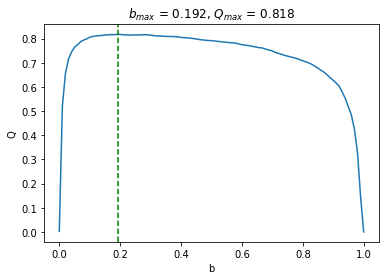

In [564]:
xmax = np.mean(xs[ys == np.max(ys)])
#plt.figure(figsize=(16,8))
plt.plot(xs, ys)
plt.axvline(xmax, ls="dashed", c="green")
plt.title("$b_{max}$ = %.3f, $Q_{max}$ = %.3f" % (xmax, np.max(ys)))
plt.xlabel("b")
plt.ylabel("Q")
plt.savefig('f1_thresh_random1000.eps', bbox_inches='tight', dpi=300)
plt.show()

In [495]:
%%time

metrics = [
    ("Precision", precision_score, 1),
    ("Recall", recall_score, 1),
    ("F1", f1_score, 1),
    ("ROC-AUC", roc_auc_score, 0),
]

for metric_name, metric, binary_flag in metrics:
    if binary_flag:
        values = [metric(x, y[:, 1] >= 0.5) for x, y in zip(tests, scores)]
    else:
        values = [metric(x, y[:, 1]) for x, y in zip(tests, scores)]
    print("%s: %.4f +- %.4f" % (metric_name, np.mean(values), np.std(values)))
print("Train time: %.4f +- %.4f" % (np.mean(times), np.std(times)))

Precision: 0.7893 +- 0.0000
Recall: 0.7463 +- 0.0000
F1: 0.7672 +- 0.0000
ROC-AUC: 0.9322 +- 0.0000
Train time: 383.7036 +- 0.0000
CPU times: user 1.32 s, sys: 128 ms, total: 1.45 s
Wall time: 1.45 s


In [132]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.1, \
                                                                                 random_state=0)

In [133]:
X_train.shape

(6843, 6)

In [134]:
X_test.shape

(761, 6)

In [135]:
collections.Counter(y)

Counter({0: 3865, 1: 3739})

In [136]:
collections.Counter(y_train)

Counter({0: 3474, 1: 3369})

In [137]:
collections.Counter(y_test)

Counter({0: 391, 1: 370})

In [57]:
neg_idx, *_ = np.where(y == 0)
pos_idx, *_ = np.where(y == 1)

In [159]:
pos_size = (y == 1).sum()
neg_size = 1 * pos_size

In [160]:
y[neg_idx].sum()

0

In [161]:
# Random
np.random.seed(0)
neg_idx_random = np.random.choice(neg_idx, neg_size, replace=False)
X_random = np.vstack([X[neg_idx_random], X[pos_idx]])
y_random = np.hstack([y[neg_idx_random], y[pos_idx]])

In [162]:
%%time

# y0 = (y == 0).sum()
# y1 = (y == 1).sum()
# neg_idx_top = kde_predict_proba(neg_array, y0, y1) > 0.027 # HYPErparameter

# X_top = np.vstack([neg_array[neg_idx_top], pos_array])
# y_top = np.array([0] * neg_idx_top.sum() + [1] * len(pos_array))

# np.random.seed(0)
# random_idx = np.random.choice(X_top.shape[0], size=X_top.shape[0], replace=False)

# X_top, y_top = X_top[random_idx], y_top[random_idx]

# clf_lr = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=0, solver="liblinear",
#                             max_iter=100, n_jobs=1)
# clf_lr.fit(X_top, y_top)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 67 µs


In [163]:
X_2d = np.vstack([np.mean(X[:, :3], axis=1), np.mean(X[:, 3:5], axis=1)]).T

In [164]:
#X_train_2d = np.vstack([np.mean(X_train[:, :3], axis=1), np.mean(X_train[:, 3:6], axis=1)]).T
#X_test_2d = np.vstack([np.mean(X_test[:, :3], axis=1), np.mean(X_test[:, 3:6], axis=1)]).T
X_random_2d = np.vstack([np.mean(X_random[:, :3], axis=1), np.mean(X_random[:, 3:5], axis=1)]).T

In [613]:
%%time

clf_lr = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=0, solver="liblinear",
                            max_iter=100, n_jobs=1)
clf_lr.fit(X_2d[:, :], y)

CPU times: user 18.4 s, sys: 3.65 s, total: 22 s
Wall time: 24.8 s


In [614]:
xx, yy = np.mgrid[0:1:.001, 0:1:.001]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf_lr.predict_proba(grid)[:, 1].reshape(xx.shape)

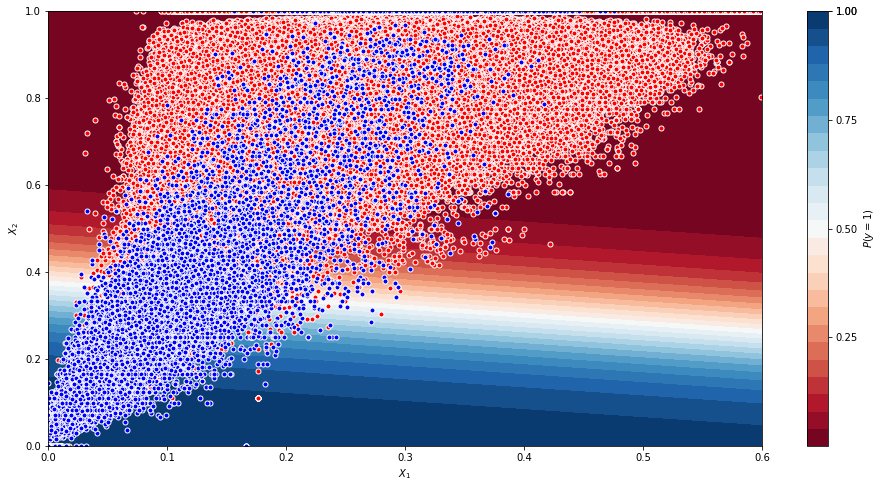

In [615]:
f, ax = plt.subplots(figsize=(16, 8))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([1, .75, .5, .25, 1])

neg_ones = (y == 0)
pos_ones = (y == 1)

ax.scatter(X_2d[neg_ones, 0], X_2d[neg_ones, 1], c="red", s=25, edgecolor="white", linewidth=1)
ax.scatter(X_2d[pos_ones, 0], X_2d[pos_ones, 1], c="blue", s=25, edgecolor="white", linewidth=1)
# ax.scatter(X_random_2d[:, 0], X_random_2d[:, 1], c=np.array(["red", "blue"])[y_random], s=5)
# ax.scatter(X_random_2d[:, 0], X_random_2d[:, 1], c=np.array(["red", "blue"])[y_random], s=5)

ax.set(xlim=(0, .6), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

plt.savefig('random1000.png', bbox_inches='tight', dpi=300)
plt.show()

In [169]:
clf_lr.coef_ # 1

array([[ -4.78942942, -12.44748973]])

In [158]:
clf_lr.coef_ # 10

array([[ -3.98833333, -14.61130616]])

In [146]:
clf_lr.coef_ # 100

array([[ -3.37434601, -15.57227347]])

---

In [46]:
%%time

clf_lr = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=0, solver="liblinear",
                            max_iter=100, n_jobs=1)
clf_lr.fit(X_2d[:, :], y)

CPU times: user 20.7 s, sys: 4.54 s, total: 25.3 s
Wall time: 25.9 s


In [105]:
from sklearn.svm import SVC

In [ ]:
%%time

clf_svm = SVC()
clf_svm.fit(X_2d[:, :], y[:])

In [ ]:
with open("classifier2.0_dialog_manpar_svm.mdl", "wb") as fout:
    pickle.dump(clf_svm, fout)

In [57]:
with open("classifier2.0_dialog_manpar_rf.mdl", "wb") as fout:
    pickle.dump(clf_rf, fout)

In [191]:
with open("classifier2.0_dialog_manpar2.mdl", "wb") as fout:
    pickle.dump(clf_lr, fout)

In [350]:
%%time

clf_lr = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=0, solver="liblinear",
                            max_iter=100, n_jobs=1)
clf_lr.fit(X_random_2d, y_random)

CPU times: user 49.6 ms, sys: 14.4 ms, total: 64 ms
Wall time: 64.1 ms


In [544]:
%time y_pred_proba = clf_lr.predict_proba(X_test_2d)[:, 1]

CPU times: user 1.63 ms, sys: 2.71 ms, total: 4.35 ms
Wall time: 11.3 ms


HBox(children=(IntProgress(value=0), HTML(value='')))

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


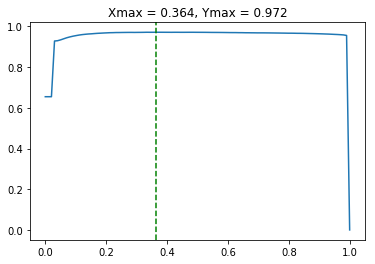

CPU times: user 896 ms, sys: 96.4 ms, total: 992 ms
Wall time: 1.19 s


In [545]:
%%time

xs = np.linspace(0, 1, 100)
ys = []

for thresh in tqdm_notebook(xs):
    y_pred = (y_pred_proba > thresh)
    score = f1_score(y_test, y_pred)
    ys.append(score)

xmax = np.mean(xs[ys == np.max(ys)])
plt.plot(xs, ys)
plt.axvline(xmax, ls="dashed", c="green")
plt.title("Xmax = %.3f, Ymax = %.3f" % (xmax, np.max(ys)))
plt.show()

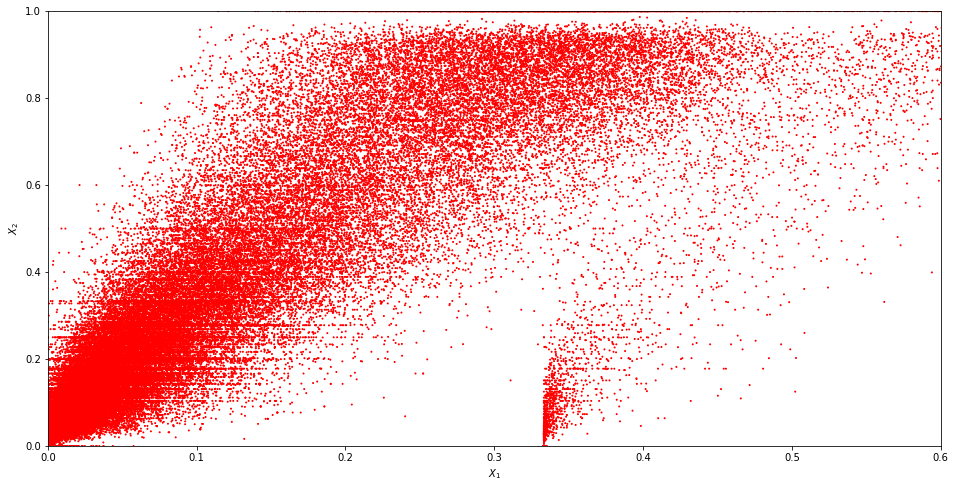

In [611]:
f, ax = plt.subplots(figsize=(16, 8))
# contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu")
# ax_c = f.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([1, .75, .5, .25, 1])

col = np.int32(y)

# ax.scatter(neg_test_2d[:, 0], neg_test_2d[:, 1], c="blue", s=1)
# ax.scatter(pos_test_2d[:, 0], pos_test_2d[:, 1], c="red", s=25, edgecolor="white", linewidth=1)
# ax.scatter(X_random_2d[:, 0], X_random_2d[:, 1], c=np.array(["blue", "red"])[y_random], s=5)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=np.array(["blue", "red"])[col], s=1)

ax.set(xlim=(0, .6), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

#plt.savefig("mle_manpar.png", bbox_inches="tight")
plt.show()

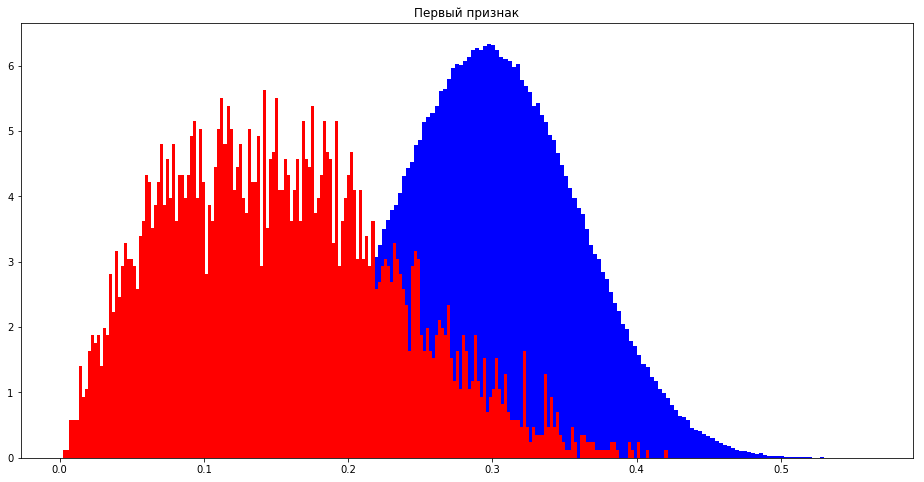

In [342]:
xs = np.linspace(0, 1, 200)
plt.figure(figsize=(16, 8))
plt.hist(neg_array[:, 0], bins=200, color="blue", normed=1)
plt.hist(pos_array[:, 0], bins=200, color="red", normed=1)
plt.title("Первый признак")
#plt.xlabel("$X_4, X_5$")
#plt.savefig("x45_beta.png", bbox_inches="tight")
plt.show()

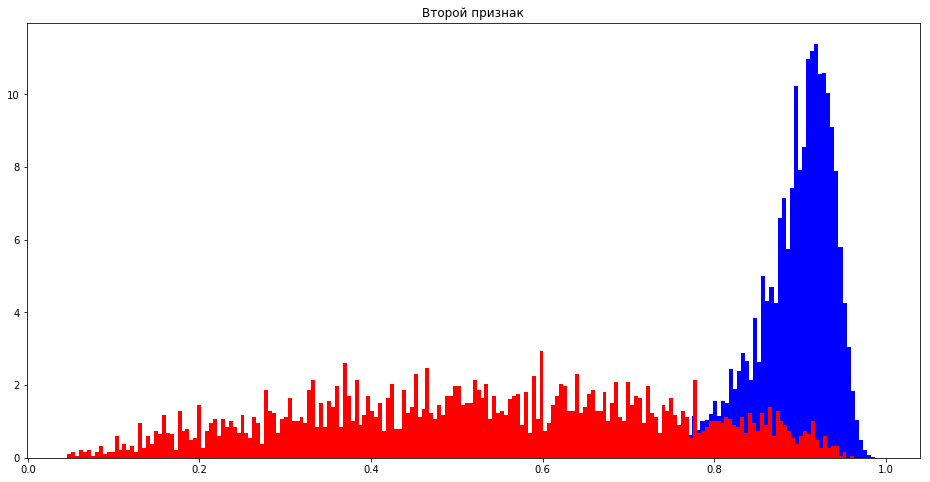

In [343]:
xs = np.linspace(0, 1, 200)
plt.figure(figsize=(16, 8))
plt.hist(neg_array[:, 1], bins=200, color="blue", normed=1)
plt.hist(pos_array[:, 1], bins=200, color="red", normed=1)
plt.title("Второй признак")
#plt.xlabel("$X_4, X_5$")
#plt.savefig("x45_beta.png", bbox_inches="tight")
plt.show()

---

In [ ]:
%%time

clf_rf = RandomForestClassifier(random_state=0, n_estimators=25, n_jobs=-1)
clf_rf.fit(X_random_2d, y_random)

In [373]:
y_pred_proba = clf_rf.predict_proba(X_test_2d)[:, 1]
y_pred = y_pred_proba > 0.50
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_proba))

             precision    recall  f1-score   support

          0       1.00      0.99      1.00   1685588
          1       0.17      0.92      0.28      1856

avg / total       1.00      0.99      1.00   1687444

[[1677001    8587]
 [    141    1715]]
0.974786497941


In [54]:
X_train_2d = np.vstack([np.mean(X_train[:, :3], axis=1), np.mean(X_train[:, 3:6], axis=1)]).T

In [55]:
X_test_2d = np.vstack([np.mean(X_test[:, :3], axis=1), np.mean(X_test[:, 3:6], axis=1)]).T

In [61]:
X_random_2d = np.vstack([np.mean(X_random[:, :3], axis=1), np.mean(X_random[:, 3:6], axis=1)]).T

In [62]:
X_random_2d.shape

(181610, 2)

In [63]:
X_test_2d.shape

(1687444, 2)

In [359]:
%%time

clf_lr = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=0, solver="liblinear",
                            max_iter=100, n_jobs=1)
clf_lr.fit(X_train[:, :5], y_train)

CPU times: user 26.7 s, sys: 7.24 s, total: 34 s
Wall time: 37.5 s


In [360]:
clf_lr.coef_, clf_lr.intercept_

(array([[-4.48466751,  0.95927305,  0.66310628, -7.57755455, -6.90303959]]),
 array([ 5.41745201]))

In [361]:
y_pred_proba = clf_lr.predict_proba(X_test[:, :5])[:, 1]
y_pred = y_pred_proba > 0.5
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_proba))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1685588
          1       0.88      0.77      0.82      1856

avg / total       1.00      1.00      1.00   1687444

[[1685392     196]
 [    429    1427]]
0.981460346536


In [338]:
%%time

clf_lr = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=0, solver="liblinear",
                            max_iter=100, n_jobs=1)
clf_lr.fit(X_train_2d, y_train)

CPU times: user 18.7 s, sys: 3.37 s, total: 22.1 s
Wall time: 23.4 s


In [339]:
clf_lr.coef_, clf_lr.intercept_

(array([[ -3.28424281, -14.74433647]]), array([ 5.82042996]))

In [340]:
y_pred_proba = clf_lr.predict_proba(X_test_2d)[:, 1]
y_pred = y_pred_proba > 0.5
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_proba))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1685588
          1       0.88      0.75      0.81      1856

avg / total       1.00      1.00      1.00   1687444

[[1685391     197]
 [    461    1395]]
0.98057007905


In [153]:
%%time

clf_lr = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=0, solver="liblinear",
                            max_iter=100, n_jobs=1)
clf_lr.fit(X_random_2d, y_random)

CPU times: user 28.2 ms, sys: 3.33 ms, total: 31.6 ms
Wall time: 30.8 ms


In [160]:
clf_lr.coef_, clf_lr.intercept_

(array([[ -4.98186096, -12.35941849]]), array([ 10.53219693]))

In [164]:
y_pred_proba = clf_lr.predict_proba(X_test_2d)[:, 1]
y_pred = y_pred_proba > 0.99
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_proba))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1685588
          1       0.84      0.83      0.83      1856

avg / total       1.00      1.00      1.00   1687444

[[1685287     301]
 [    312    1544]]
0.980682712734


---

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


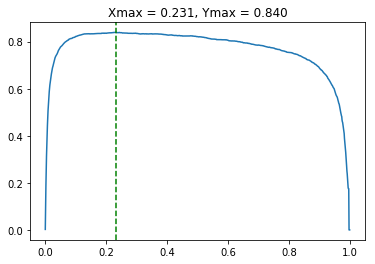

CPU times: user 3min 3s, sys: 7.42 s, total: 3min 10s
Wall time: 3min 11s


In [177]:
%%time

xs = np.arange(0, 1.000, 0.001)
ys = []

for thresh in tqdm_notebook(xs):
    y_pred = (y_pred_proba > thresh)
    score = f1_score(y_test, y_pred)
    ys.append(score)

xmax = np.mean(xs[ys == np.max(ys)])
plt.plot(xs, ys)
plt.axvline(xmax, ls="dashed", c="green")
plt.title("Xmax = %.3f, Ymax = %.3f" % (xmax, np.max(ys)))
plt.show()

HBox(children=(IntProgress(value=0, max=250), HTML(value='')))

Exception in thread Thread-19:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



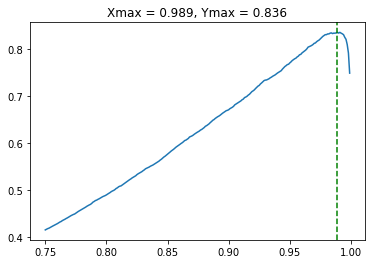

CPU times: user 48.8 s, sys: 3.06 s, total: 51.9 s
Wall time: 54.1 s


In [171]:
%%time

xs = np.arange(0.250, 0.750, 0.001)
ys = []

for thresh in tqdm_notebook(xs):
    y_pred = (y_pred_proba > thresh)
    score = f1_score(y_test, y_pred)
    ys.append(score)

xmax = np.mean(xs[ys == np.max(ys)])
plt.plot(xs, ys)
plt.axvline(xmax, ls="dashed", c="green")
plt.title("Xmax = %.3f, Ymax = %.3f" % (xmax, np.max(ys)))
plt.show()

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

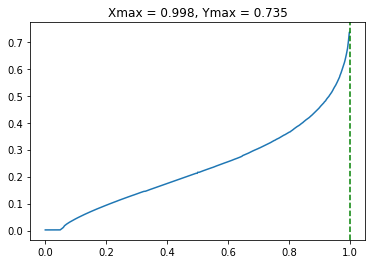

CPU times: user 3min 11s, sys: 9.58 s, total: 3min 20s
Wall time: 3min 21s


In [213]:
%%time

xs = np.arange(0, 1.000, 0.001)
ys = []

for thresh in tqdm_notebook(xs):
    y_pred = (y_pred_proba > thresh)
    score = f1_score(y_test, y_pred)
    ys.append(score)

xmax = np.mean(xs[ys == np.max(ys)])
plt.plot(xs, ys)
plt.axvline(xmax, ls="dashed", c="green")
plt.title("Xmax = %.3f, Ymax = %.3f" % (xmax, np.max(ys)))
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [462]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['f1']

In [463]:
(y_train == 0).sum() / (y_train == 1).sum()

918.86650514839494

In [467]:
%%time

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring="%s_macro" % score,
                       n_jobs=-1)
    clf.fit(X_random_2d, y_random)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    break

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_2d)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.967 (+/-0.003) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.938 (+/-0.002) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.971 (+/-0.003) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.967 (+/-0.003) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.972 (+/-0.002) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.971 (+/-0.003) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.973 (+/-0.002) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.972 (+/-0.002) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.973 (+/-0.002) for {'C': 1, 'kernel': 'linear'}
0.973 (+/-0.002) for {'C': 10, 'kernel': 'linear'}
0.973 (+/-0.002) for {'C': 100, 'kernel': 'linear'}
0.973 (+/-0.002) for {'C': 1000, 'kernel': 'linear'}

CPU times: user 4.92 s, sys: 298 ms, total: 5.22 s
Wall time: 9min 6s


In [475]:
%%time

clf_svm = SVC(probability=True, class_weight=None, max_iter=-1, random_state=0,
              **clf.best_params_)
clf_svm.fit(X_random_2d, y_random)

CPU times: user 2min 3s, sys: 18.2 s, total: 2min 22s
Wall time: 2min 22s


In [476]:
y_pred_proba = clf_svm.predict_proba(X_test_2d)[:, 1]
y_pred = y_pred_proba > 0.5
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_proba))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1685588
          1       0.25      0.93      0.40      1856

avg / total       1.00      1.00      1.00   1687444

[[1680538    5050]
 [    138    1718]]
0.980580683018


In [743]:
test_outliers = np.any((X_test_2d < 0.001) | (X_test_2d > 0.999), axis=1)

np.random.seed(0)
pos_test_2d = X_test_2d[~test_outliers & (y_test == 1)]

neg_idx_2d = np.random.choice((~test_outliers & (y_test == 0)).sum(), size=10 * len(pos_test_2d), replace=False)
neg_test_2d = X_test_2d[~test_outliers & (y_test == 0)][neg_idx_2d]

In [394]:
xx, yy = np.mgrid[0:1:.001, 0:1:.001]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

[(0, 1), Text(0,0.5,'$X_2$'), (0, 0.6), Text(0.5,0,'$X_1$')]

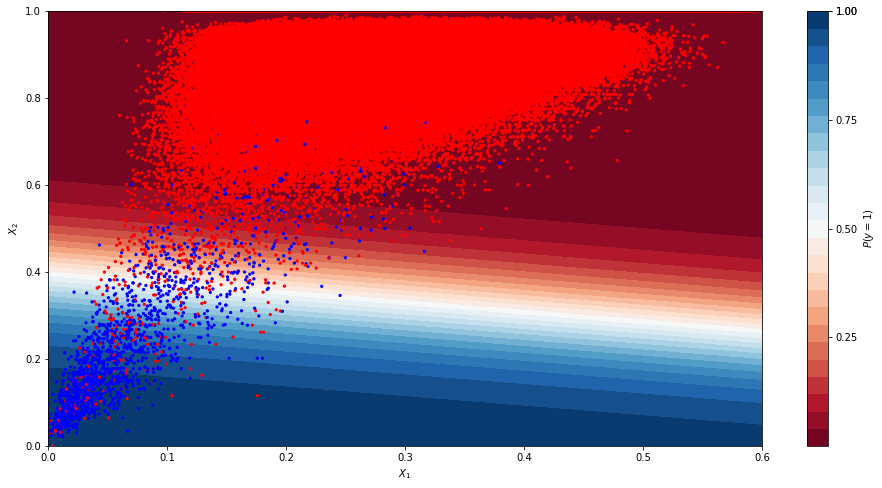

In [398]:
f, ax = plt.subplots(figsize=(16, 8))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([1, .75, .5, .25, 1])

# ax.scatter(neg_test_2d[:, 0], neg_test_2d[:, 1], c="red", s=5)
# ax.scatter(pos_test_2d[:, 0], pos_test_2d[:, 1], c="blue", s=25, edgecolor="white", linewidth=1)
ax.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=np.array(["red", "blue"])[y_test], s=5)

ax.set(xlim=(0, .6), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

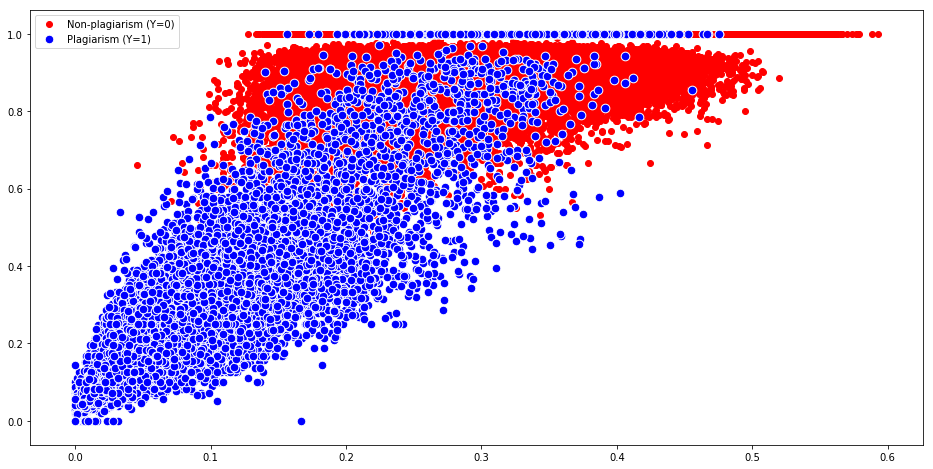

In [236]:
plt.figure(figsize=(16, 8))
plt.scatter(X_random_2d[y_random == 0][:, 0], X_random_2d[y_random == 0][:, 1], c="red")
plt.scatter(X_random_2d[y_random == 1][:, 0], X_random_2d[y_random == 1][:, 1], c="blue", s=75,
            edgecolor="white", linewidth=1)
plt.legend(["Non-plagiarism (Y=0)", "Plagiarism (Y=1)"])

---

In [242]:
import matplotlib.mlab as mlab

In [243]:
import seaborn as sns

In [244]:
from scipy.stats import norm, beta, gaussian_kde
from scipy.stats.mstats import normaltest

In [140]:
from fastkde import fastKDE

In [138]:
from scipy.interpolate import RectBivariateSpline, interp2d

In [616]:
outliers = np.any((X_2d < 0.001) | (X_2d > 0.999), axis=1)

In [618]:
neg_array = X_2d[~outliers & (y == 0)]
pos_array = X_2d[~outliers & (y == 1)]
#mu = np.mean(neg_array)
#sigma = np.std(neg_array)

In [249]:
%time kde0 = fastKDE.fastKDE([neg_array[:, 0], neg_array[:, 1]], numPoints=1025, ecfPrecision=1)

CPU times: user 8.52 s, sys: 173 ms, total: 8.7 s
Wall time: 8.75 s


In [619]:
%time kde1 = fastKDE.fastKDE([pos_array[:, 0], pos_array[:, 1]], numPoints=1025, ecfPrecision=1)

CPU times: user 3.65 s, sys: 510 ms, total: 4.16 s
Wall time: 4.8 s


In [620]:
%%time

#kde_approx0 = RectBivariateSpline(kde0.axes[0], kde0.axes[1], kde0.pdf.T)
kde_approx1 = RectBivariateSpline(kde1.axes[0], kde1.axes[1], kde1.pdf.T)

CPU times: user 69.7 ms, sys: 6.38 ms, total: 76.1 ms
Wall time: 81.5 ms


In [ ]:
%%time

gkde = gaussian_kde(pos_array.T)
xx, yy = np.meshgrid(np.linspace(0, 1, 1025), np.linspace(0, 1, 1025))
z = np.c_[xx.flatten(), yy.flatten()]
y_gkde = gkde.pdf(z.T)
y_gkde = y_gkde.reshape(1025, 1025)
kde_approx1_ = RectBivariateSpline(np.linspace(0, 1, 1025), np.linspace(0, 1, 1025), y_gkde.T)

In [224]:
eps = 1e-9

def kde_predict_proba(X, y0, y1):
    score0 = np.abs(kde_approx0.ev(X[:, 0], X[:, 1]) * y0 / (y0 + y1)) # p(x|y=0) * p(y=0)
    score1 = np.abs(kde_approx1.ev(X[:, 0], X[:, 1]) * y1 / (y0 + y1)) # p(x|y=1) * p(y=1)
    px = score0 + score1
    px_is_zero = (px <= eps)
    score = np.array(score1)
    score[~px_is_zero] = score[~px_is_zero] / px[~px_is_zero] # p(x|y=1) * p(y=1) / p(x)
    score[px_is_zero] = 0.
    score[X[:, 1] >= 0.999] = 0.
    score[X[:, 1] <= 0.001] = 1.
    return np.vstack([1 - score, score]).T

In [253]:
len(pos_array)

4078

In [254]:
y0 = (y == 0).sum()
y1 = (y == 1).sum()

In [260]:
%time (kde_predict_proba(neg_array, y0, y1) > 0.027).sum()

CPU times: user 1.07 s, sys: 17.9 ms, total: 1.09 s
Wall time: 1.1 s


4052

---

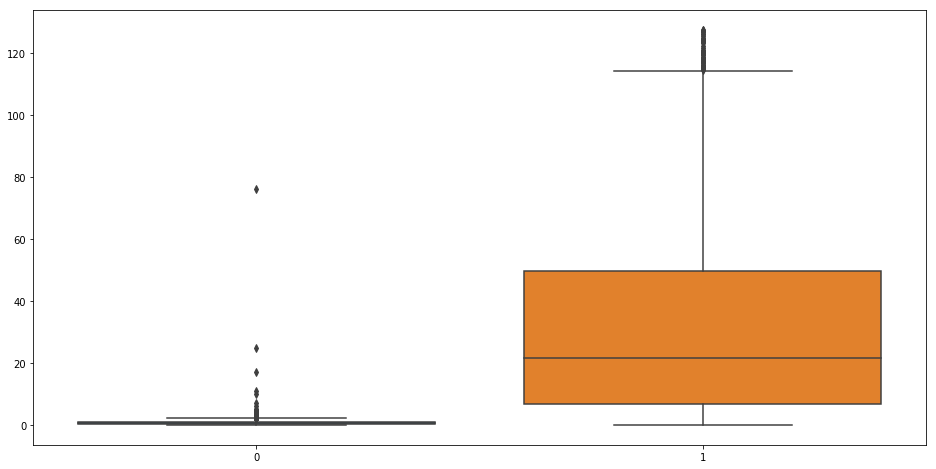

In [998]:
neg_scores = kde_decision_function(neg_test_2d)
pos_scores = kde_decision_function(pos_test_2d)

plt.figure(figsize=(16, 8))
sns.boxplot(data=[neg_scores, pos_scores])

In [999]:
%%time

y_pred_score = kde_decision_function(X_test_2d)

CPU times: user 1.32 s, sys: 22.1 ms, total: 1.34 s
Wall time: 1.37 s


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

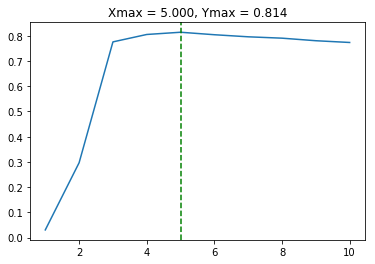

CPU times: user 2.1 s, sys: 151 ms, total: 2.25 s
Wall time: 2.31 s


In [1000]:
%%time

xs = np.linspace(1, 10, 10)
ys = []

for thresh in tqdm_notebook(xs):
    y_pred = (y_pred_score > thresh)
    score = f1_score(y_test, y_pred)
    ys.append(score)

xmax = np.mean(xs[ys == np.max(ys)])
plt.plot(xs, ys)
plt.axvline(xmax, ls="dashed", c="green")
plt.title("Xmax = %.3f, Ymax = %.3f" % (xmax, np.max(ys)))
plt.show()

In [1002]:
y_pred = y_pred_score > 5
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_score))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1685588
          1       0.83      0.79      0.81      1856

avg / total       1.00      1.00      1.00   1687444

[[1685295     293]
 [    382    1474]]
0.973432426531


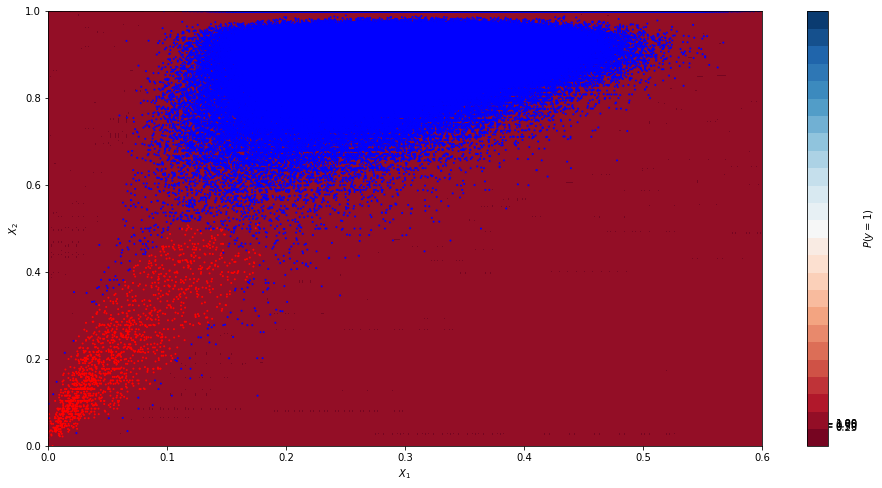

In [1003]:
f, ax = plt.subplots(figsize=(16, 8))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu")
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([1, .75, .5, .25, 1])

col = np.int32(y_pred_score > 5)

# ax.scatter(neg_test_2d[:, 0], neg_test_2d[:, 1], c="blue", s=1)
# ax.scatter(pos_test_2d[:, 0], pos_test_2d[:, 1], c="red", s=25, edgecolor="white", linewidth=1)
# ax.scatter(X_random_2d[:, 0], X_random_2d[:, 1], c=np.array(["blue", "red"])[y_random], s=5)
ax.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=np.array(["blue", "red"])[col], s=1)

ax.set(xlim=(0, .6), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

#plt.savefig("mle_manpar.png", bbox_inches="tight")
plt.show()

Распределение первого признака

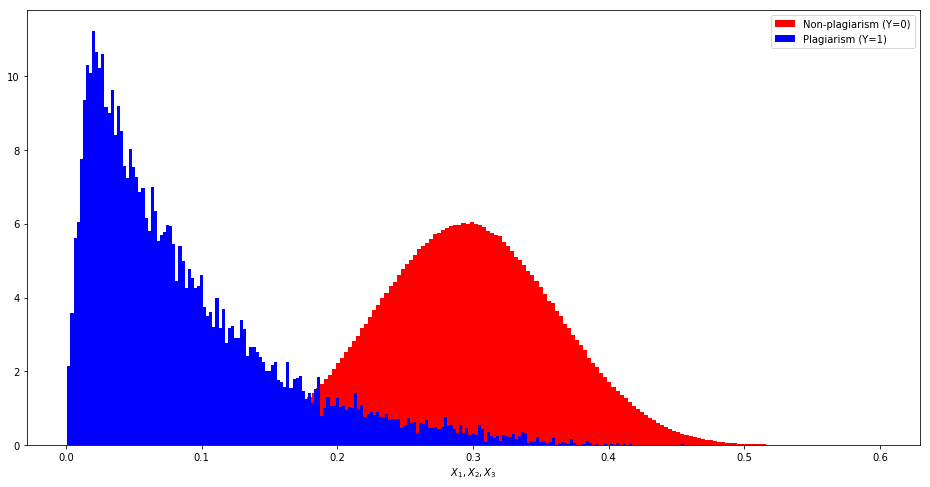

In [762]:
plt.figure(figsize=(16, 8))
n, bins, patches = plt.hist(neg_array[:, 0], bins=200, color="red", normed=1)
plt.hist(pos_array[:, 0], bins=200, color="blue", normed=1)
#plt.plot(bins, mlab.normpdf(bins, mu, sigma))
plt.xlabel("$X_1, X_2, X_3$")
plt.legend(["Non-plagiarism (Y=0)", "Plagiarism (Y=1)"])
plt.savefig("x123_distrib.png", bbox_inches="tight")
plt.show()

In [123]:
mu, sigma

(0.34111902866257154, 0.069809586451787628)

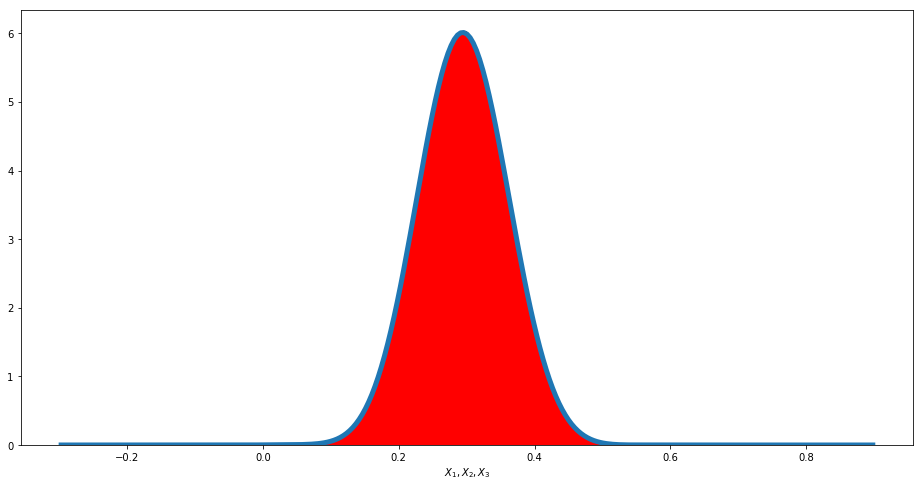

CPU times: user 1.04 s, sys: 76.2 ms, total: 1.12 s
Wall time: 1.19 s


In [402]:
%%time

xs = np.linspace(0, 0.6, 200)
plt.figure(figsize=(16, 8))
n, bins, patches = plt.hist(neg_array[:, 0], bins=200, color="red", normed=1)
#plt.plot(bins, mlab.normpdf(bins, mu, sigma), linewidth=5)
plt.plot(x_kde, z_kde, linewidth=5)
plt.xlabel("$X_1, X_2, X_3$")
plt.savefig("x123_normal.png", bbox_inches="tight")
plt.show()

In [ ]:
%%time

plt.figure(figsize=(16, 8))
probplot(neg_array, dist=norm(loc=mu, scale=sigma), plot=plt)
plt.savefig("x123_probplot.png", bbox_inches="tight")
plt.show()

Распределение второго признака

In [166]:
neg_array = X_train[y_train == 0][:, 3:6].mean(axis=1)
#neg_array = neg_array[neg_array < 0.999]
pos_array = pos_array[(pos_array > 0.001) & (pos_array < 0.999)]

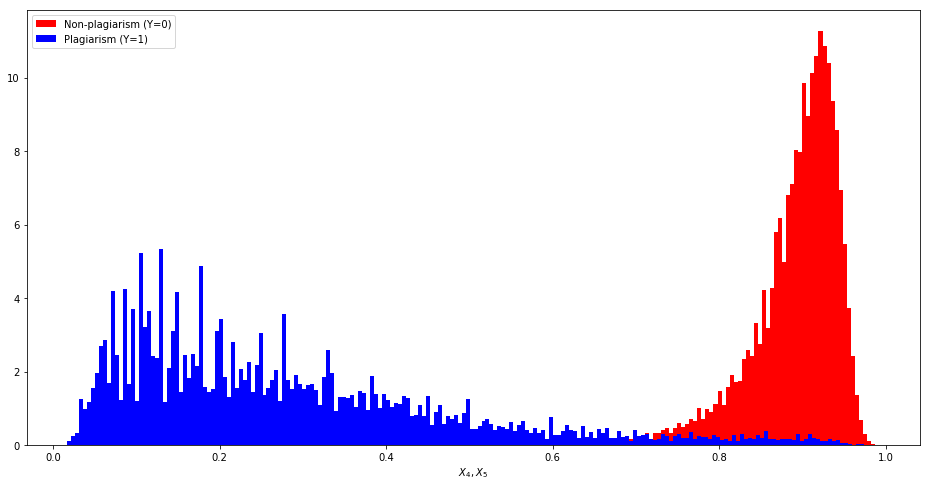

In [806]:
plt.figure(figsize=(16, 8))
n, bins, patches = plt.hist(neg_array[:, 1], bins=200, color="red", normed=1)
plt.hist(pos_array[:, 1], bins=200, color="blue", normed=1)
plt.xlabel("$X_4, X_5$")
plt.legend(["Non-plagiarism (Y=0)", "Plagiarism (Y=1)"])
plt.savefig("x45_distrib.png", bbox_inches="tight")
plt.show()

In [128]:
%%time

np.random.seed(1)
X_t = np.random.choice(neg_array, size=1000000, replace=False)

x1 = gaussian_kde(neg_array)

CPU times: user 176 ms, sys: 11.3 ms, total: 187 ms
Wall time: 187 ms


In [ ]:
%%time

a, b, loc, scale = beta.fit(neg_array)

In [1292]:
a, b, loc, scale

(268.39812948592402,
 3.9848979434298597,
 -4.7214697493709732,
 5.7144604549115599)

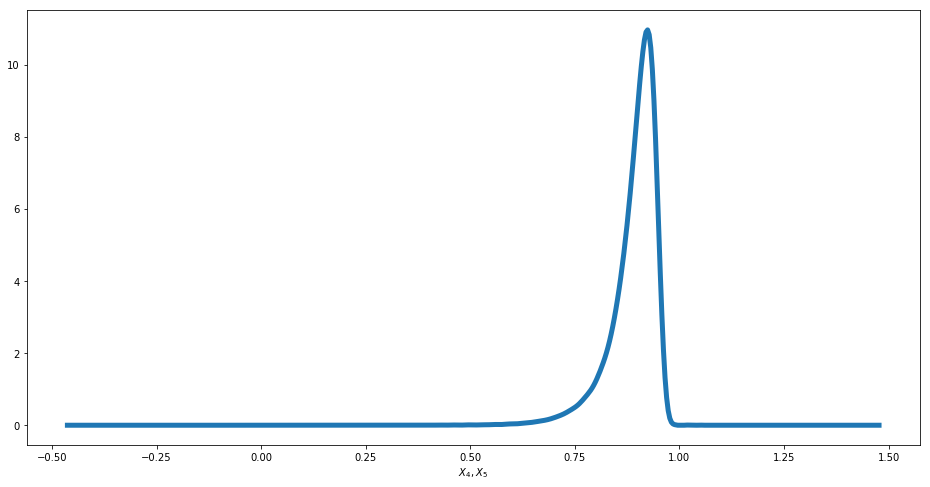

In [405]:
xs = np.linspace(0, 1, 200)
plt.figure(figsize=(16, 8))
#plt.hist(neg_array[:, 1], bins=200, color="red", normed=1)
#plt.plot(xs, beta.pdf(xs, a=a, b=b, loc=loc, scale=scale), linewidth=5)
plt.plot(x_kde, z_kde, linewidth=5)
plt.xlabel("$X_4, X_5$")
#plt.savefig("x45_beta.png", bbox_inches="tight")
plt.show()

HBox(children=(IntProgress(value=0), HTML(value='')))

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


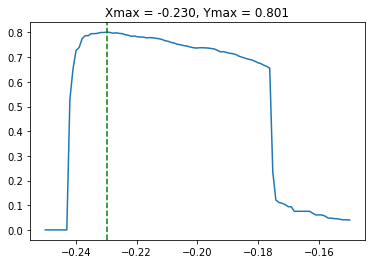

CPU times: user 19.7 s, sys: 977 ms, total: 20.7 s
Wall time: 21.2 s


In [1152]:
%%time

xs = np.linspace(-0.25, -0.15, 100)
ys = []

for thresh in tqdm_notebook(xs):
    y_pred = (y_pred_score <= thresh)
    score = f1_score(y_test, y_pred)
    ys.append(score)

xmax = np.mean(xs[ys == np.max(ys)])
plt.plot(xs, ys)
plt.axvline(xmax, ls="dashed", c="green")
plt.title("Xmax = %.3f, Ymax = %.3f" % (xmax, np.max(ys)))
plt.show()

In [ ]:
%%time

plt.figure(figsize=(16, 8))
probplot(neg_array, dist=beta(a, b, loc, scale), plot=plt)
plt.savefig("x45_probplot.png", bbox_inches="tight")
plt.show()

Построение разделяющей поверхности

In [130]:
def mle_transform_function(X):
    p0 = x0.pdf(X[:, 0]).reshape(-1, 1)
    p1 = x1.pdf(X[:, 1]).reshape(-1, 1)
#     p0 = ((X[:, 0] > x0.ppf(0.0013)) & (X[:, 0] < x0.ppf(0.9987))).reshape(-1, 1)
#     p1 = ((X[:, 1] > x1.ppf(0.0013)) & (X[:, 1] < x1.ppf(0.9987))).reshape(-1, 1)
    return np.hstack([p0, p1])

def mle_decision_function(X):
    trans = mle_transform_function(X)
    return np.sqrt((trans[:, 0] ** 2) + (trans[:, 1] ** 2))

In [725]:
%%time

xx, yy = np.mgrid[0:1:.001, 0:1:.001]
probs = kde_approx.ev(xx, yy)

CPU times: user 678 ms, sys: 8.19 ms, total: 686 ms
Wall time: 693 ms


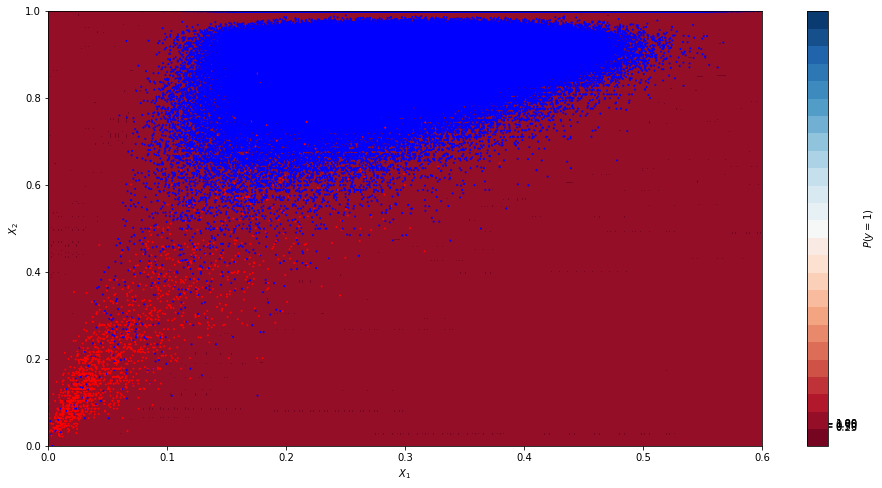

In [808]:
f, ax = plt.subplots(figsize=(16, 8))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu")
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([1, .75, .5, .25, 1])

# ax.scatter(neg_test_2d[:, 0], neg_test_2d[:, 1], c="blue", s=1)
# ax.scatter(pos_test_2d[:, 0], pos_test_2d[:, 1], c="red", s=25, edgecolor="white", linewidth=1)
# ax.scatter(X_random_2d[:, 0], X_random_2d[:, 1], c=np.array(["blue", "red"])[y_random], s=5)
ax.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=np.array(["blue", "red"])[y_test], s=1)

ax.set(xlim=(0, .6), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

#plt.savefig("mle_manpar.png", bbox_inches="tight")
plt.show()

---

In [56]:
neg_idx, *_ = np.where(y_train == 0)
pos_idx, *_ = np.where(y_train == 1)

In [57]:
pos_size = (y_train == 1).sum()
neg_size = int((y_train == 0).sum() / (y_train == 1).sum() * 0.01 * pos_size)  # 1% от всех негативных примеров
neg_size = 10 * pos_size

In [58]:
y_train[neg_idx].sum()

0

In [59]:
# Random
np.random.seed(0)
neg_idx_random = np.random.choice(neg_idx, neg_size, replace=False)
X_random = np.vstack([X_train[neg_idx_random], X_train[pos_idx]])
y_random = np.hstack([y_train[neg_idx_random], y_train[pos_idx]])

In [60]:
X_random.shape

(181610, 6)

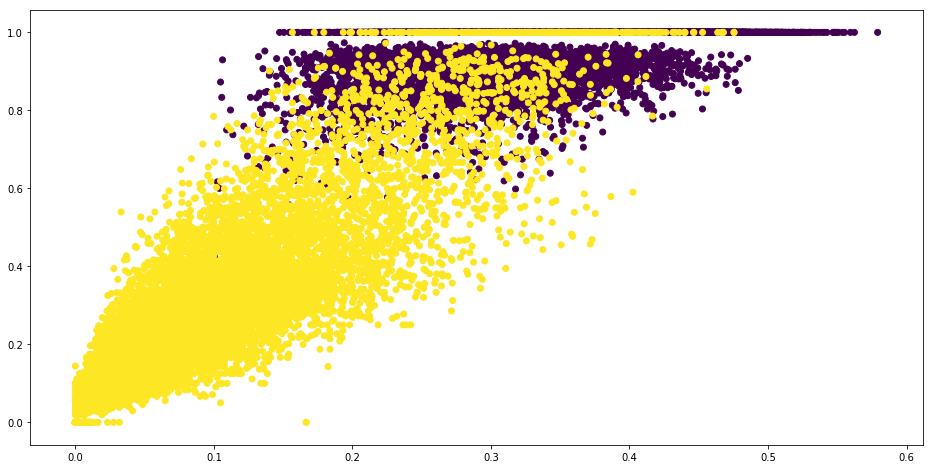

In [291]:
eps = 1e-9
plt.figure(figsize=(16, 8))
plt.scatter(np.mean(X_random[:, :3] + eps, axis=1), np.mean(X_random[:, 3:5] + eps, axis=1), c=y_random)

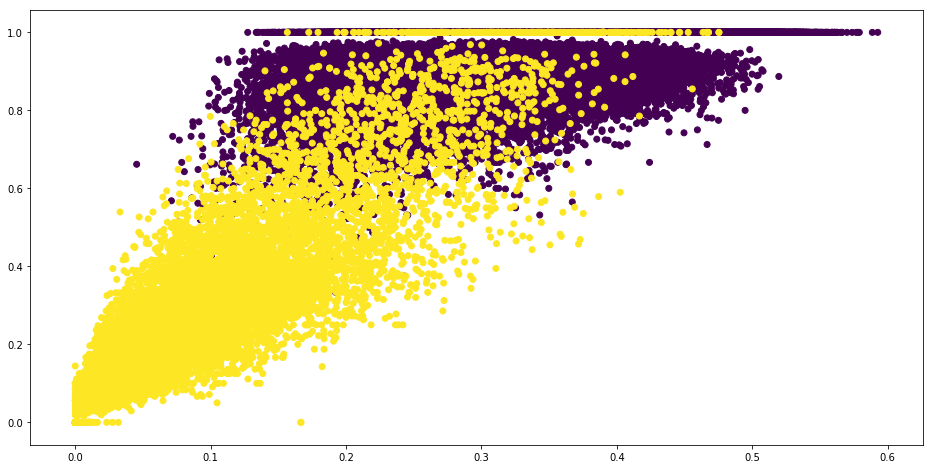

In [286]:
eps = 1e-9
plt.figure(figsize=(16, 8))
plt.scatter(np.mean(X_random[:, :3] + eps, axis=1), np.mean(X_random[:, 3:5] + eps, axis=1), c=y_random)

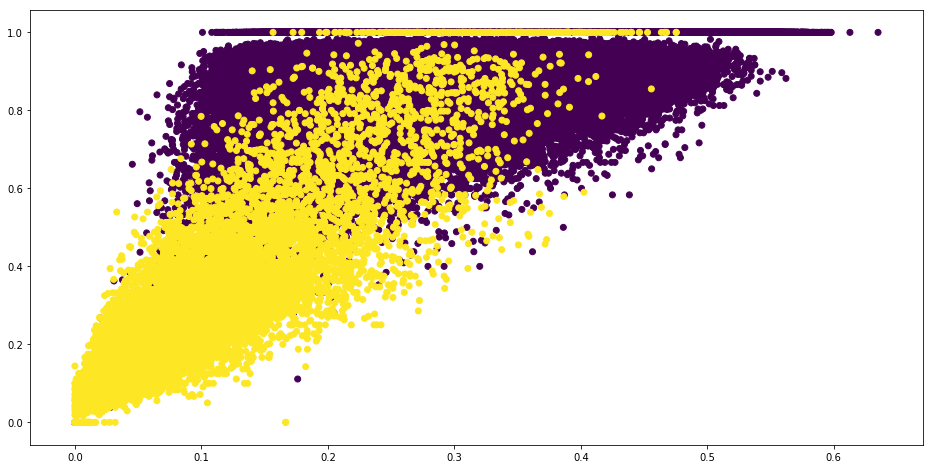

In [296]:
eps = 1e-9
plt.figure(figsize=(16, 8))
plt.scatter(np.mean(X_random[:, :3] + eps, axis=1), np.mean(X_random[:, 3:5] + eps, axis=1), c=y_random)

In [60]:
from sklearn.manifold import TSNE

In [61]:
%%time

np.random.seed(228)
tsne = TSNE(perplexity=200, n_iter=1000, metric="euclidean", init="pca", random_state=0)
tsne_idx_random = np.random.choice(len(X_random), 2000, replace=False)
x_tsne = tsne.fit_transform(X_random[tsne_idx_random][:, :5])
y_tsne = y_random[tsne_idx_random]

CPU times: user 16.5 s, sys: 886 ms, total: 17.4 s
Wall time: 17.9 s


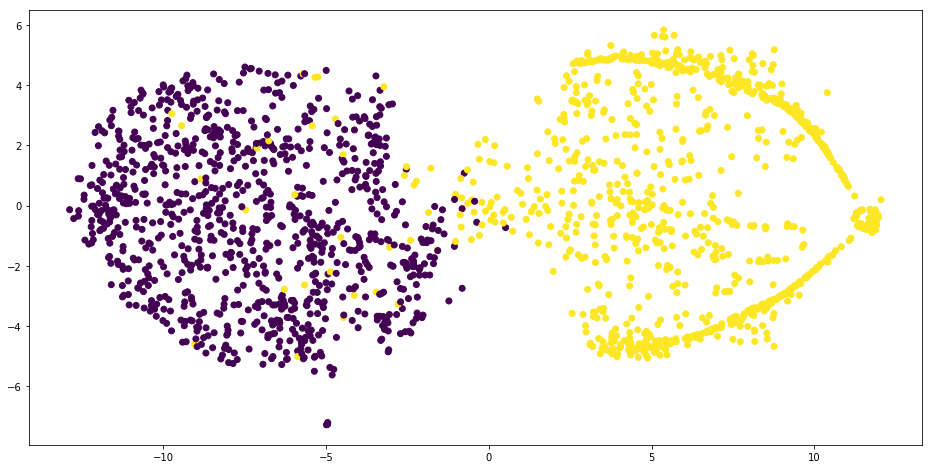

In [62]:
plt.figure(figsize=(16, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_tsne)
plt.savefig("tsne_genpar.png", bbox_inches="tight")

In [63]:
from scipy.stats import hmean

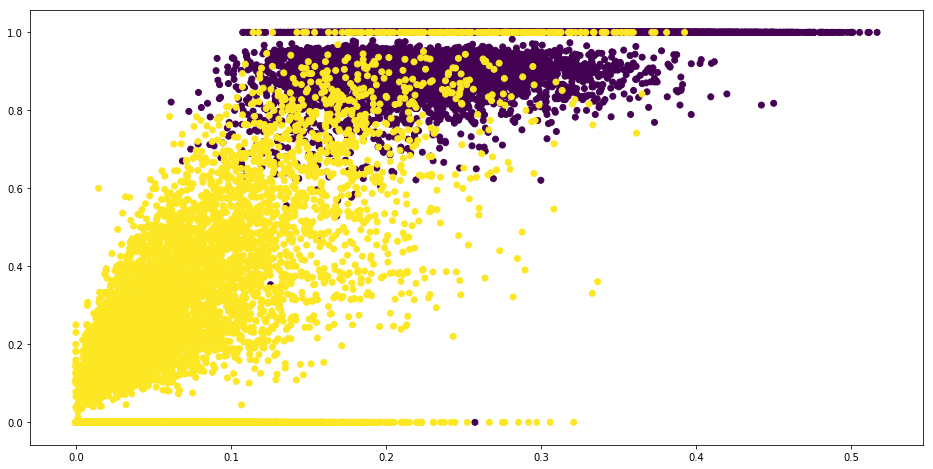

In [64]:
eps = 1e-9
plt.figure(figsize=(16, 8))
plt.scatter(hmean(X_random[:, :3] + eps, axis=1), hmean(X_random[:, 3:5] + eps, axis=1), c=y_random)

In [71]:
((hmean(X_random[:, 3:5] + eps, axis=1) > 0.75) & (y_random == 1)).sum() / sum(y_random == 1)

0.033731188375713546

In [70]:
((hmean(X_random[:, 3:5] + eps, axis=1) <= 0.75) & (y_random == 0)).sum() / sum(y_random == 0)

0.0098598858329008825

One-class SVM (novelty detection)

In [978]:
from sklearn.svm import OneClassSVM

In [1024]:
%%time

X_t = X_random_2d[y_random == 0]
X_t = X_t[(X_t[:, 1] > 0.001) & (X_t[:, 1] < 0.999)]
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.01)
clf.fit(X_t)
y_pred_train = clf.predict(X_t)
y_pred_test = clf.predict(neg_test_2d)
y_pred_outliers = clf.predict(pos_test_2d)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

CPU times: user 104 ms, sys: 1.21 ms, total: 106 ms
Wall time: 105 ms


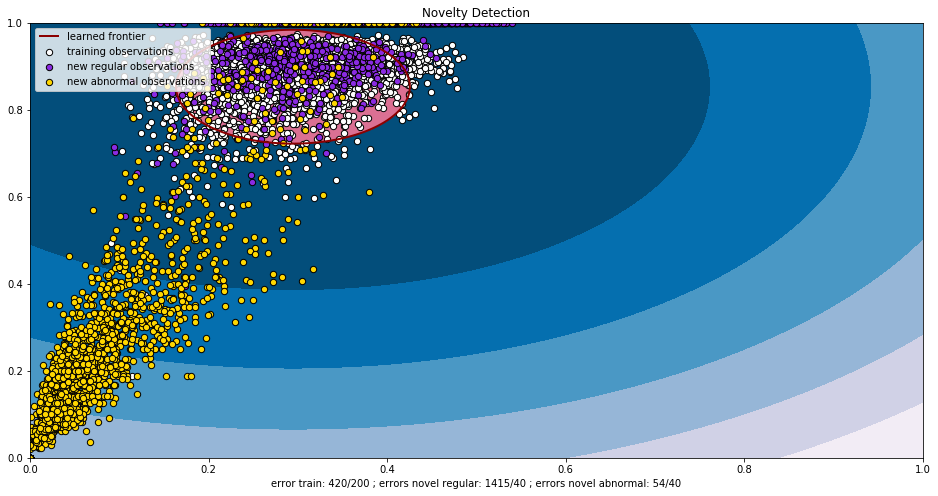

CPU times: user 1.92 s, sys: 36.1 ms, total: 1.96 s
Wall time: 1.98 s


In [1025]:
%%time

xx, yy = np.meshgrid(np.linspace(0, 1, 500), np.linspace(0, 1, 500))

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(16, 8))

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_t[:, 0], X_t[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(neg_test_2d[:, 0], neg_test_2d[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(pos_test_2d[:, 0], pos_test_2d[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

Robust Covariance Estimation (Outlier detection)

In [1027]:
from sklearn.covariance import MinCovDet, EmpiricalCovariance

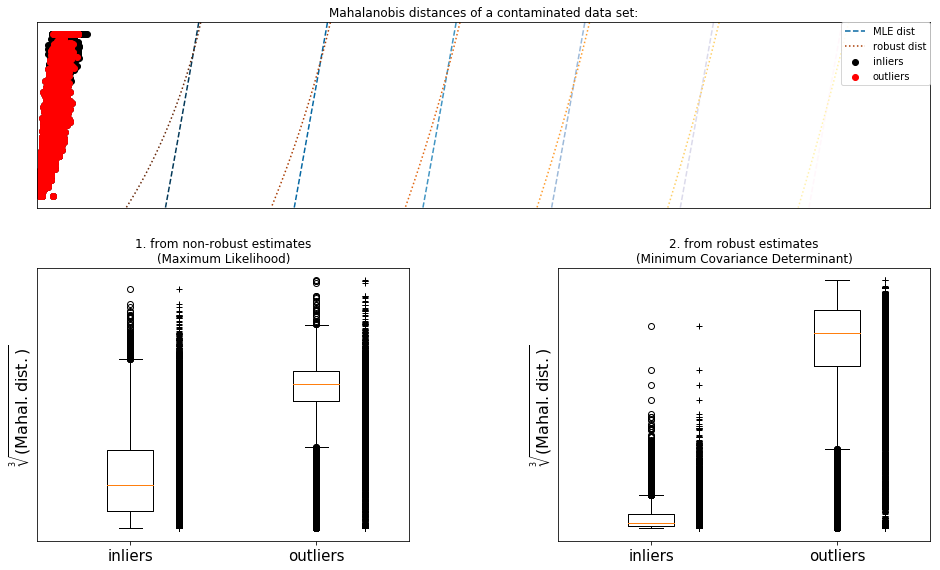

CPU times: user 10.6 s, sys: 192 ms, total: 10.8 s
Wall time: 10.9 s


In [1033]:
%%time

def rce(pos_samples, neg_samples):
    X = np.vstack([neg_samples, pos_samples])
    n_samples = len(X)
    n_outliers = len(pos_samples)
    
    # Create train data
    # fit a Minimum Covariance Determinant (MCD) robust estimator to data
    robust_cov = MinCovDet().fit(X)

    # compare estimators learnt from the full data set with true parameters
    emp_cov = EmpiricalCovariance().fit(X)

    # #############################################################################
    # Display results
    fig = plt.figure(figsize=(16, 8))
    plt.subplots_adjust(hspace=-.1, wspace=.4, top=.95, bottom=.05)

    # Show data set
    subfig1 = plt.subplot(3, 1, 1)
    inlier_plot = subfig1.scatter(X[:, 0], X[:, 1],
                                  color='black', label='inliers')
    outlier_plot = subfig1.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:],
                                   color='red', label='outliers')
    subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
    subfig1.set_title("Mahalanobis distances of a contaminated data set:")

    # Show contours of the distance functions
    xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                         np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
    zz = np.c_[xx.ravel(), yy.ravel()]

    mahal_emp_cov = emp_cov.mahalanobis(zz)
    mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
    emp_cov_contour = subfig1.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                      cmap=plt.cm.PuBu_r,
                                      linestyles='dashed')

    mahal_robust_cov = robust_cov.mahalanobis(zz)
    mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
    robust_contour = subfig1.contour(xx, yy, np.sqrt(mahal_robust_cov),
                                     cmap=plt.cm.YlOrBr_r, linestyles='dotted')

    subfig1.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
                    inlier_plot, outlier_plot],
                   ['MLE dist', 'robust dist', 'inliers', 'outliers'],
                   loc="upper right", borderaxespad=0)
    plt.xticks(())
    plt.yticks(())

    # Plot the scores for each point
    emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)
    subfig2 = plt.subplot(2, 2, 3)
    subfig2.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
    subfig2.plot(1.26 * np.ones(n_samples - n_outliers),
                 emp_mahal[:-n_outliers], '+k', markeredgewidth=1)
    subfig2.plot(2.26 * np.ones(n_outliers),
                 emp_mahal[-n_outliers:], '+k', markeredgewidth=1)
    subfig2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
    subfig2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
    subfig2.set_title("1. from non-robust estimates\n(Maximum Likelihood)")
    plt.yticks(())

    robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
    subfig3 = plt.subplot(2, 2, 4)
    subfig3.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]],
                    widths=.25)
    subfig3.plot(1.26 * np.ones(n_samples - n_outliers),
                 robust_mahal[:-n_outliers], '+k', markeredgewidth=1)
    subfig3.plot(2.26 * np.ones(n_outliers),
                 robust_mahal[-n_outliers:], '+k', markeredgewidth=1)
    subfig3.axes.set_xticklabels(('inliers', 'outliers'), size=15)
    subfig3.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
    subfig3.set_title("2. from robust estimates\n(Minimum Covariance Determinant)")
    plt.yticks(())

    plt.show()
    
    return robust_cov, emp_cov

robust_cov, emp_cov = rce(X_random_2d[y_random == 1], X_random_2d[y_random == 0])

In [1039]:
robust_cov.covariance_

array([[ 0.005204  ,  0.00220065],
       [ 0.00220065,  0.00438991]])

Isolation Forest (Outlier Detection):

In [1045]:
from sklearn.ensemble import IsolationForest

In [1069]:
X_t.shape

(424346, 2)

In [1079]:
%%time

# create train data
X_t = X_train_2d[y_train == 0]
X_t = X_t[(X_t[:, 1] > 0.001) & (X_t[:, 1] < 0.999)]

# fit the model
clf = IsolationForest(max_samples=250, n_estimators=100, random_state=0, contamination=(y_train == 1).sum() / len(y_train))
clf.fit(X_t)
y_pred_train = clf.predict(X_t)
y_pred_test = clf.predict(neg_test_2d)
y_pred_outliers = clf.predict(pos_test_2d)

CPU times: user 3min 39s, sys: 4min 4s, total: 7min 43s
Wall time: 9min 58s


In [1154]:
with open("classifier2.0_dialog_manpar_isoforest.mdl", "wb") as fout:
    pickle.dump(clf, fout)

In [1155]:
with open("classifier2.0_dialog_manpar_isoforest.mdl", "rb") as fin:
    clf = pickle.load(fin)

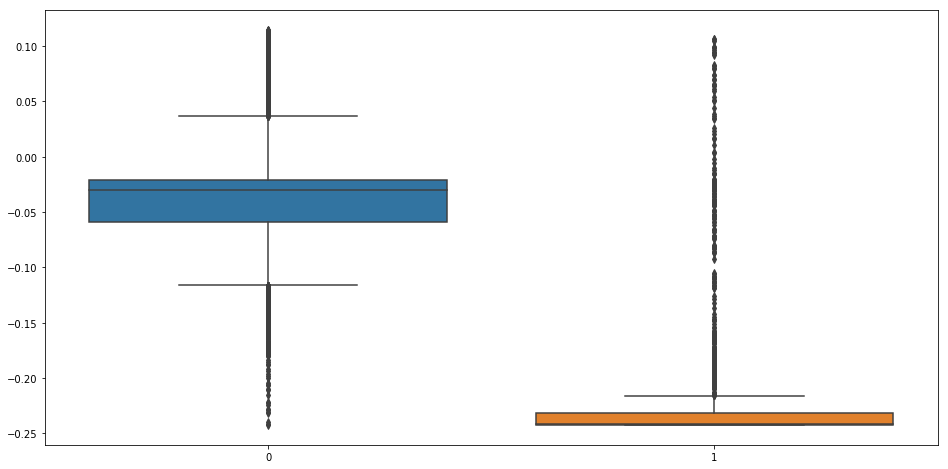

In [1147]:
neg_scores = clf.decision_function(neg_test_2d)
pos_scores = clf.decision_function(pos_test_2d)

plt.figure(figsize=(16, 8))
sns.boxplot(data=[neg_scores, pos_scores])

In [1148]:
%time y_pred_score = clf.decision_function(X_test_2d)

In [1162]:
roc_auc_score(y_test, 1 - y_pred_score)

0.95985585523547579

HBox(children=(IntProgress(value=0), HTML(value='')))

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


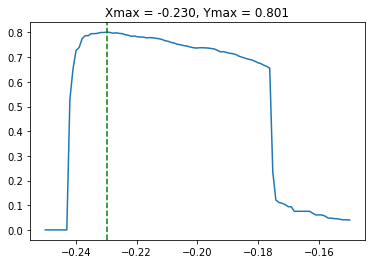

CPU times: user 19.7 s, sys: 977 ms, total: 20.7 s
Wall time: 21.2 s


In [1152]:
%%time

xs = np.linspace(-0.25, -0.15, 100)
ys = []

for thresh in tqdm_notebook(xs):
    y_pred = (y_pred_score <= thresh)
    score = f1_score(y_test, y_pred)
    ys.append(score)

xmax = np.mean(xs[ys == np.max(ys)])
plt.plot(xs, ys)
plt.axvline(xmax, ls="dashed", c="green")
plt.title("Xmax = %.3f, Ymax = %.3f" % (xmax, np.max(ys)))
plt.show()

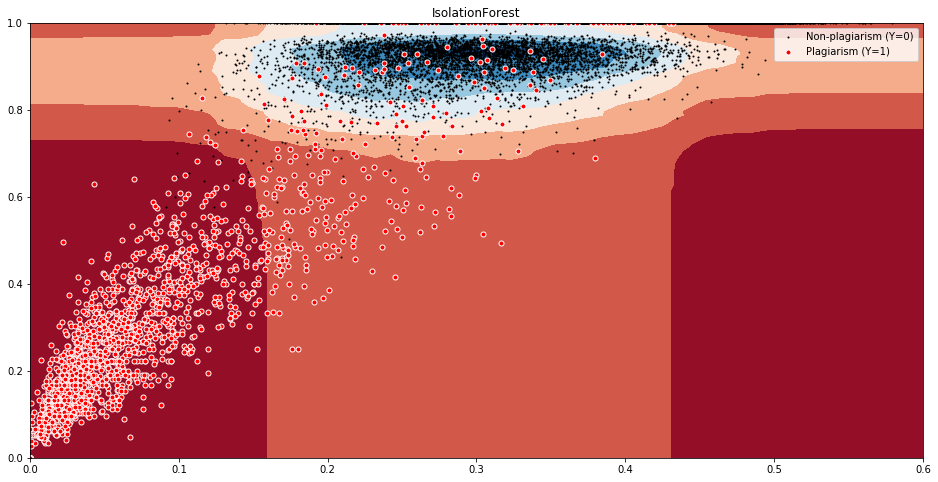

In [1103]:
# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(16, 8))
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap="RdBu")

# b1 = plt.scatter(X_t[:, 0], X_t[:, 1], c='white',
#                  s=20, edgecolor='k')
b2 = plt.scatter(neg_test_2d[:, 0], neg_test_2d[:, 1], c='blue',
                 s=1, edgecolor='k')
c = plt.scatter(pos_test_2d[:, 0], pos_test_2d[:, 1], c='red',
                s=25, edgecolor='white', linewidth=1)
plt.axis('tight')
plt.legend([b2, c],
           ["Non-plagiarism (Y=0)", "Plagiarism (Y=1)"],
           loc="upper right")
plt.xlim((0, 0.6))
plt.ylim((0, 1))
plt.savefig("isoforest_manpar.png", bbox_inches="tight")
plt.show()

TODO: [Local outlier factor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)

---

In [72]:
with open("train_data.dump", "wb") as fout:
    pickle.dump((X, y, indices), fout)

In [73]:
with open("train_data.dump", "rb") as fin:
    X, y, indices = pickle.load(fin)

## Model selection

In [116]:
%%time

features_names = np.array(["rusvectores", "fasttext", "starspace", "left_inclusion", "right_inclusion"])
clfs = [("random_forest", RandomForestClassifier(random_state=0, n_estimators=25, n_jobs=-1)), \
        ("log_regression", LogisticRegression())]

rows = []

for clf_name, clf in clfs:
    for n in range(1, len(features_names) + 1):
        for indices in itertools.combinations(range(len(features_names)), n):
            names = ", ".join(map(features_names.__getitem__, indices))
            score = cross_val_score(clf, X[:, indices], y, scoring="f1", cv=5).mean()
            rows.append((names, score, clf_name))

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

CPU times: user 9min 49s, sys: 7.12 s, total: 9min 56s
Wall time: 3min 26s


In [117]:
df = pd.DataFrame(rows, columns=["Признаки", "F1 на кросс-валидации", "Классификатор"])
df.to_excel("features_subsets_score_random10.xls")

In [119]:
%%time

features_names = np.array(["rusvectores", "fasttext", "starspace", "left_inclusion", "right_inclusion"])
clfs = [("random_forest", RandomForestClassifier(random_state=0, n_estimators=25, n_jobs=-1)), \
        ("log_regression", LogisticRegression())]

rows2 = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

for clf_name, clf in clfs:
    clf.fit(X_train, y_train)
    for n in range(1, len(features_names) + 1):
        for indices in itertools.combinations(range(len(features_names)), n):
            names = ", ".join(map(features_names.__getitem__, indices))
            X_test_mod = np.copy(X_test)
            X_test_mod[:, indices] =  X_test_mod[:, indices].min(axis=0) + X_test_mod[:, indices].max(axis=0) - \
                                      X_test_mod[:, indices]
            y_pred = clf.predict_proba(X_test)[:, 1]
            y_pred_mod = clf.predict_proba(X_test_mod)[:, 1]
            score = np.mean(np.abs(y_pred - y_pred_mod))
            rows2.append((names, score, clf_name))

CPU times: user 10.1 s, sys: 211 ms, total: 10.3 s
Wall time: 8.6 s


In [122]:
X_test.shape

(21158, 5)

In [120]:
df2 = pd.DataFrame(rows2, columns=["Признаки", "Сила влияния", "Классификатор"])
df2.to_excel("features_subsets_score2_random10.xls")

## Model

In [73]:
clf = RandomForestClassifier(random_state=0, n_estimators=25, n_jobs=-1)

In [86]:
clf = LogisticRegression()

In [87]:
%time cross_val_score(clf, X[:, 0:1], y, scoring="f1", cv=3).mean()

CPU times: user 1.65 s, sys: 0 ns, total: 1.65 s
Wall time: 1.63 s


0.77025603286448607

In [88]:
%time cross_val_score(clf, X[:, 1:2], y, scoring="f1", cv=3).mean()

CPU times: user 1.62 s, sys: 1 ms, total: 1.63 s
Wall time: 1.61 s


0.69818185738617178

In [89]:
%time cross_val_score(clf, X[:, 2:3], y, scoring="f1", cv=3).mean()

CPU times: user 1.61 s, sys: 1e+03 µs, total: 1.61 s
Wall time: 1.6 s


0.76181006948320551

In [90]:
%time cross_val_score(clf, X[:, 0:2], y, scoring="f1", cv=3).mean()

CPU times: user 1.83 s, sys: 0 ns, total: 1.83 s
Wall time: 1.8 s


0.7856700674027951

In [91]:
%time cross_val_score(clf, X[:, 1:3], y, scoring="f1", cv=3).mean()

CPU times: user 2.14 s, sys: 1 ms, total: 2.14 s
Wall time: 2.12 s


0.8092625318640122

In [92]:
%time cross_val_score(clf, X[:, [0, 2]], y, scoring="f1", cv=3).mean()

CPU times: user 1.76 s, sys: 1e+03 µs, total: 1.76 s
Wall time: 1.74 s


0.82702753828201947

In [93]:
%time cross_val_score(clf, X[:, :3], y, scoring="f1", cv=3).mean()

CPU times: user 1.67 s, sys: 0 ns, total: 1.67 s
Wall time: 1.65 s


0.8321745732073258

In [94]:
%time cross_val_score(clf, X[:, -5:], y, scoring="f1", cv=3).mean()

CPU times: user 11 s, sys: 3 ms, total: 11 s
Wall time: 11 s


0.92282825603432073

In [95]:
%time cross_val_score(clf, X, y, scoring="f1", cv=3).mean()

CPU times: user 4.68 s, sys: 1e+03 µs, total: 4.68 s
Wall time: 4.66 s


0.92033803678200166

In [35]:
%time cross_val_score(clf, X, y, scoring="precision", cv=3).mean()

CPU times: user 13.6 s, sys: 0 ns, total: 13.6 s
Wall time: 13.6 s


0.9125462033837265

In [36]:
%time cross_val_score(clf, X, y, scoring="recall", cv=3).mean()

CPU times: user 11.4 s, sys: 0 ns, total: 11.4 s
Wall time: 11.4 s


0.83014583879137194

In [37]:
%time cross_val_score(clf, X, y, scoring="accuracy", cv=3).mean()

CPU times: user 11.7 s, sys: 1e+03 µs, total: 11.7 s
Wall time: 11.7 s


0.98662382169353702

### Error analysis

In [46]:
idx = np.array(list(range(len(X))))
X_train, X_test, y_train, y_test, _, test_idx = train_test_split(X[:, :], y, idx, test_size=0.1, random_state=0)

In [219]:
X_test_hard, y_test_hard = np.copy(X_test), np.copy(y_test)

In [122]:
X_test_easy, y_test_easy = np.copy(X_test), np.copy(y_test)

#### Logistic regression classifier

In [119]:
clf = LogisticRegression(random_state=0, C=1)

In [120]:
%time clf.fit(X_train, y_train)

CPU times: user 4.83 s, sys: 552 ms, total: 5.38 s
Wall time: 5.44 s


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

From now on should be re-evaluation!

In [123]:
X_test, y_test = X_test_easy, y_test_easy
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred = y_pred_proba > 0.5
precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

(0.95503483217226093,
 0.86319404693760737,
 0.90679494888755263,
 0.93149669790528489)

In [280]:
X_test, y_test = X_test_hard, y_test_hard
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred = y_pred_proba > 0.5
precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

(0.9595588235294118,
 0.87242339832869076,
 0.91391887948643125,
 0.93518573927005044)

Text(0.5,1,'2-class ROC curve: AUC=0.9914')

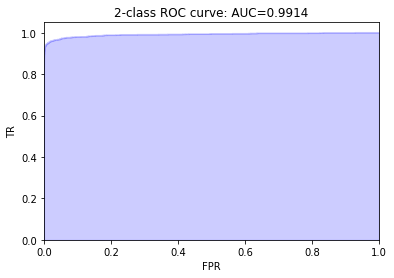

In [124]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.step(fpr, tpr, color='b', alpha=0.2,
         where='post')
plt.fill_between(fpr, tpr, step='post', alpha=0.2,
                 color='b')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class ROC curve: AUC={0:0.4f}'.format(
          roc_auc))

Text(0.5,1,'2-class Precision-Recall curve: AUC=0.9259')

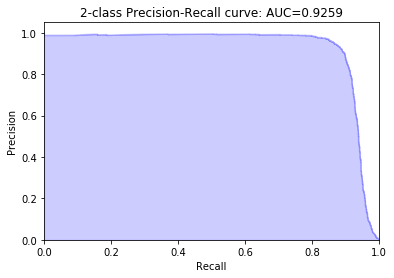

In [125]:
average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.4f}'.format(
          average_precision))

In [126]:
clf.intercept_, clf.coef_

(array([ 8.11386886]),
 array([[-2.94813141,  5.62171914, -6.9645662 , -7.4773481 , -6.65723874]]))

In [128]:
confusion_matrix(y_test, y_pred)

array([[353777,     71],
       [   239,   1508]])

#### Random forest classifier

In [ ]:
clf = RandomForestClassifier(random_state=0, n_estimators=25, n_jobs=-1)

In [ ]:
%time clf.fit(X_train, y_train)

In [86]:
clf.feature_importances_

array([ 0.14238351,  0.05855069,  0.2511285 ,  0.29667859,  0.25125871])

In [87]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]

Text(0.5,1,'2-class Precision-Recall curve: AUC=0.8938')

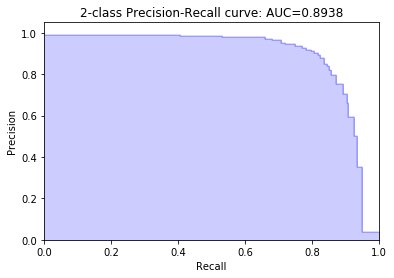

In [88]:
average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.4f}'.format(
          average_precision))

In [122]:
for t, i in enumerate(test_idx[(y_test == 1) & (y_pred == 0)]):
    if t == 2:
        print(repr(" ".join(susps[i])))
        print(repr(" ".join(srcs[i])))
        print(X[i], clf.predict_proba([X[i]]))
        print(set(susps[i]) & set(srcs[i]))
        print()

'детство_NOUN есенин_NOUN наблюдаться_VERB частый_ADJ смена_NOUN настроение_NOUN баловаться_VERB доходить_VERB богохульство_NOUN переходить_VERB молитва_NOUN'
'детство_NOUN очень_ADV резкий_ADJ переход_NOUN полоса_NOUN молитвенный_ADJ необычайный_ADJ озорство_NOUN вплоть_ADV богохульство_NOUN'
[ 0.17561361  0.1463706   0.06542188  0.81818182  0.8       ] [[ 0.8  0.2]]
{'детство_NOUN', 'богохульство_NOUN'}



**Save classifier on disk:**

In [311]:
clf = RandomForestClassifier(random_state=0, n_estimators=25, n_jobs=-1)

In [358]:
clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=0, solver="liblinear",
                         max_iter=100, n_jobs=-1)

In [359]:
#w = samples_weights.sum(axis=1)
#w = np.divide(w, w.sum())

In [360]:
X_2d = np.vstack([np.mean(X[:, :3], axis=1), np.mean(X[:, 3:6], axis=1)]).T

In [361]:
%time clf.fit(X_2d, y)

CPU times: user 20.8 s, sys: 3.59 s, total: 24.4 s
Wall time: 25.1 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [362]:
clf.coef_, clf.intercept_

(array([[ -3.25242683, -14.77202598]]), array([ 5.83046835]))

In [319]:
clf.feature_importances_

array([ 0.09955012,  0.24900837,  0.07238513,  0.30042183,  0.27863455])

In [363]:
with open("classifier2.0_dialog_manpar.mdl", "wb") as fout:
    pickle.dump(clf, fout)

# Evaluation part

In [192]:
with open("classifier2.0_dialog_manpar2.mdl", "rb") as fin:
    clf_lr = pickle.load(fin)

Проверяем качество классификатора на обучающей выборке:

In [ ]:
%%time

# Create dataset out of embeddings ranking.

embeddings_list = (rv_w_sent_embeddings, ft_sent_embeddings, ss_sent_embeddings)
features = []
labels = []
indices = []
seen_pairs = collections.defaultdict(set)
train_pairs = collections.defaultdict(set)

susps = []
srcs = []

# Прочитаем все ответы заранее
with open("dialog_train_sentences.csv") as train_file:
    header = train_file.readline().strip().split(",")
    train_reader = csv.DictReader(train_file, header)
    for row in tqdm_notebook(train_reader):
        susp_path = row["suspicious_path"]
        susp_sent_i = int(row["suspicious_sentence_id"])
        susp_sent_id = files_sentences_ids[susp_path][susp_sent_i]
        src_path = row["source_path"]
        src_sent_i = int(row["source_sentence_id"])
        src_sent_id = files_sentences_ids[src_path][src_sent_i]
        train_pairs[susp_sent_id].add(src_sent_id)

with open("dialog_train_sentences.csv") as train_file:
    header = train_file.readline().strip().split(",")
    train_reader = csv.DictReader(train_file, header)
    for row in tqdm_notebook(train_reader):
        susp_path = row["suspicious_path"]
        susp_sent_i = int(row["suspicious_sentence_id"])
        susp_sent_id = files_sentences_ids[susp_path][susp_sent_i]
        susp_lemmas = sentences_dict[susp_path][susp_sent_i]
        susp_lemmas_set = set(susp_lemmas)
        src_path = row["source_path"]
        src_sent_i = int(row["source_sentence_id"])
        src_sent_id = files_sentences_ids[src_path][src_sent_i]
        src_sents_ids = np.array(list(files_sentences_ids[src_path].values()))
        cand_sents_ids = set()
        # Шаг 1: формирование кандидатов
        for embeddings in embeddings_list:
            susp_vec = embeddings[susp_sent_id]
            src_vecs = list(map(embeddings.__getitem__, src_sents_ids))
            dists = 0.5 * (1 - cosine_similarity([susp_vec], src_vecs))[0]
            top_ranks = np.argsort(dists)
            cand_sents_ids.update(src_sents_ids[top_ranks])
        cand_sents_ids -= seen_pairs[susp_sent_id]
        seen_pairs[susp_sent_id] |= cand_sents_ids
        if len(cand_sents_ids) == 0:
            continue
        # Шаг 2: вычисление расстояния по всем эмбеддингам
        cand_sents_ids = np.array(list(cand_sents_ids))
        top_labels = list(map(train_pairs[susp_sent_id].__contains__, cand_sents_ids))
        top_indices = list(map(lambda x: (susp_sent_id, x), cand_sents_ids))
        top_dists = []
        top_products = None
        for embeddings in embeddings_list:
            susp_vec = embeddings[susp_sent_id]
            cand_vecs = list(map(embeddings.__getitem__, cand_sents_ids))
            dists = 0.5 * (1 - cosine_similarity([susp_vec], cand_vecs))[0]
            top_dists.append(dists)
        left_incl_dists = [] # susp_lemmas \in cand_lemmas
        right_incl_dists = [] # cand_lemmas \in susp_lemmas
        susp_lens_dists = []
        cand_lens_dists = []
        min_lens_dists = []
        for cand_sent_id in cand_sents_ids:
            cand_path, cand_sent_i = sentences_files_ids[cand_sent_id]
            assert cand_path == src_path
            cand_lemmas = sentences_dict[cand_path][cand_sent_i]
            cand_lemmas_set = set(cand_lemmas)
            intersection = susp_lemmas_set & cand_lemmas_set
            left_num = sum(map(intersection.__contains__, susp_lemmas))
            right_num = sum(map(intersection.__contains__, cand_lemmas))
            left_incl_dists.append(1 - left_num / len(susp_lemmas))
            right_incl_dists.append(1 - right_num / len(cand_lemmas))
            susps.append(sentences[susp_path][susp_sent_i])
            srcs.append(sentences[cand_path][cand_sent_i])
            susp_lens_dists.append(len(susp_lemmas))
            cand_lens_dists.append(len(cand_lemmas))
            min_lens_dists.append(min(len(susp_lemmas), len(cand_lemmas)))
        top_dists.append(left_incl_dists)
        top_dists.append(right_incl_dists)
        #top_dists.append(susp_lens_dists)
        #top_dists.append(cand_lens_dists)
        #top_dists.append(min_lens_dists)
        # Шаг 3: запись признаков
        for dists, y, ix in zip(zip(*top_dists), top_labels, top_indices):
            features.append(dists)
            labels.append(y)
            indices.append(ix)
        #for products, y in zip(top_products, top_labels):
        #    features.append(list(products))
        #    labels.append(y)

In [52]:
%%time

features = np.array(features)
labels = np.array(labels, dtype=np.int8).reshape(len(labels), 1)
train = np.hstack([features, labels])
X, y = train[:, :-1], np.int8(train[:, -1])
indices = np.array(indices)
del features, labels, train

CPU times: user 4.05 s, sys: 1.39 s, total: 5.44 s
Wall time: 6.27 s


In [53]:
X.shape, y.shape, len(indices)

((3120331, 5), (3120331,), 3120331)

In [54]:
%%time

y_pred_proba = clf.predict_proba(X)[:, 1]

CPU times: user 15.1 s, sys: 906 ms, total: 16 s
Wall time: 6.25 s


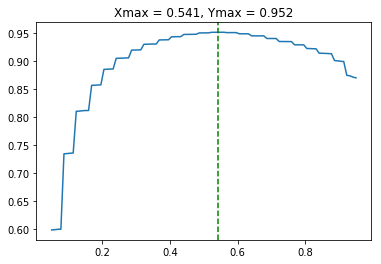

CPU times: user 48.2 s, sys: 4.02 s, total: 52.2 s
Wall time: 57.1 s


In [55]:
%%time

xs = np.linspace(0.05, 0.95, 100)
ys = []

for thresh in xs:
    y_pred = (y_pred_proba > thresh)
    score = f1_score(y, y_pred)
    ys.append(score)

xmax = np.mean(xs[ys == np.max(ys)])
plt.plot(xs, ys)
plt.axvline(xmax, ls="dashed", c="green")
plt.title("Xmax = %.3f, Ymax = %.3f" % (xmax, np.max(ys)))
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AUC=0.9643')

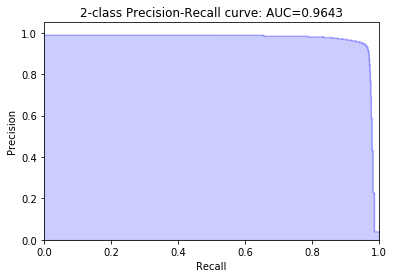

In [56]:
average_precision = average_precision_score(y, y_pred_proba)
precision, recall, _ = precision_recall_curve(y, y_pred_proba)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.4f}'.format(
          average_precision))

In [57]:
print(confusion_matrix(y, y_pred_proba > xmax))

[[2990032    6711]
 [   5269  118319]]


In [58]:
print(classification_report(y, y_pred_proba > xmax))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   2996743
          1       0.95      0.96      0.95    123588

avg / total       1.00      1.00      1.00   3120331



In [ ]:
idx = ((y == 1) & (y_pred_proba <= xmax))

for i, ((i1, i2), x, y_p) in enumerate(zip(indices[idx], X[idx], y_pred_proba[idx])):
    if y_p == 0:
        a, b = sentences_files_ids[i1]
        i1_txt = sentences_dict[a][b]
        c, d = sentences_files_ids[i2]
        i2_txt = sentences_dict[c][d]
        print(x, y_p)
        print("%s\t%d\t%s" % (a, b, " ".join(i1_txt)))
        print("%s\t%d\t%s" % (c, d, " ".join(i2_txt)))
        print()

---

In [58]:
%%time

# Create dataset out of embeddings ranking.

embeddings_list = (rv_w_sent_embeddings, ft_sent_embeddings, ss_sent_embeddings)

pre_detections_list = []

test_paths = []

with open(tasks_dir + "pairs") as fin:
    for line in tqdm_notebook(fin):
        susp_name, src_name = line.strip().split()
        susp_path, src_path = "susp/" + susp_name, "src/" + src_name
        test_paths.append((susp_path, src_path))
        susp_sents_is = list(files_sentences_ids[susp_path].keys())
        susp_sents_ids = list(files_sentences_ids[susp_path].values())
        src_sents_is = list(files_sentences_ids[src_path].keys())
        src_sents_ids = np.array(list(files_sentences_ids[src_path].values()))
        features, indices, pre_detections = [], [], []
        embed_dists = []
        for embeddings in embeddings_list:
            susp_vecs = list(map(embeddings.__getitem__, susp_sents_ids))
            cand_vecs = list(map(embeddings.__getitem__, src_sents_ids))
            dists = 0.5 * (1 - cosine_similarity(susp_vecs, cand_vecs))
            embed_dists.append(dists)
        for t1, (susp_sent_i, susp_sent_id) in enumerate(zip(susp_sents_is, susp_sents_ids)):
            susp_lemmas = sentences_dict[susp_path][susp_sent_i]
            susp_lemmas_set = set(susp_lemmas)
            # Шаг 1: вычисление расстояния по всем эмбеддингам
            top_indices = list(map(lambda x: (susp_sent_id, x), src_sents_ids))
            top_dists = []
            for dists in embed_dists:
                top_dists.append(dists[t1])
            left_incl_dists = [] # susp_lemmas \in cand_lemmas
            right_incl_dists = [] # cand_lemmas \in susp_lemmas
            iou_incl_dists = [] # intersection \in union
            susp_lens_dists = []
            cand_lens_dists = []
            min_lens_dists = []
            for cand_sent_id in src_sents_ids:
                cand_path, cand_sent_i = sentences_files_ids[cand_sent_id]
                assert cand_path == src_path
                cand_lemmas = sentences_dict[cand_path][cand_sent_i]
                cand_lemmas_set = set(cand_lemmas)
                intersection = susp_lemmas_set & cand_lemmas_set
                union = susp_lemmas + cand_lemmas
                left_num = sum(map(intersection.__contains__, susp_lemmas))
                right_num = sum(map(intersection.__contains__, cand_lemmas))
                iou_num = sum(map(intersection.__contains__, union))
                left_incl_dists.append(1 - left_num / len(susp_lemmas))
                right_incl_dists.append(1 - right_num / len(cand_lemmas))
                iou_incl_dists.append(1 - iou_num / len(union))
                susp_lens_dists.append(len(susp_lemmas))
                cand_lens_dists.append(len(cand_lemmas))
                min_lens_dists.append(min(len(susp_lemmas), len(cand_lemmas)))
            top_dists.append(left_incl_dists)
            top_dists.append(right_incl_dists)
            top_dists.append(iou_incl_dists)
            #top_dists.append(susp_lens_dists)
            #top_dists.append(cand_lens_dists)
            #top_dists.append(min_lens_dists)
            # Шаг 2: запись признаков
            for dists, ix in zip(zip(*top_dists), top_indices):
                features.append(dists)
                indices.append(ix)
        features = np.array(features)
        assert features.shape[1] == 6
        features_2d = np.vstack([np.mean(features[:, :3], axis=1), np.mean(features[:, 3:5], axis=1)]).T
        probas = clf_rf.predict_proba(features_2d[:, 0:2])[:, 1]
        #probas = kde_decision_function(features_2d)
        for (susp_sent_id, src_sent_id), p in zip(indices, probas):
            if p > 0.10:
            #if p > 0.5:
                _, susp_sent_i = sentences_files_ids[susp_sent_id]
                _, src_sent_i = sentences_files_ids[src_sent_id]
                pre_detections.append((p, susp_sent_i, src_sent_i))
        pre_detections_list.append(pre_detections)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 4min 29s, sys: 6.61 s, total: 4min 35s
Wall time: 4min 29s


In [184]:
# tmp = []

# for dlist in pre_detections_list:
#     max_p = {}
#     for p, susp_i, src_i in dlist:
#         max_p[susp_i] = max(max_p.get(susp_i, 0), p)
#     tmp.append(list(filter(lambda p: p[0] >= max_p[p[1]], dlist)))

# pre_detections_list = tmp

In [59]:
%%time

files_lens = {}

for susp_path, src_path in tqdm_notebook(test_paths):
    if susp_path not in files_lens:
        files_lens[susp_path] = sent_tokenize(open(data_dir + susp_path).read())[1]
    if src_path not in files_lens:
        files_lens[src_path] = sent_tokenize(open(data_dir + src_path).read())[1]

HBox(children=(IntProgress(value=0, max=713), HTML(value='')))


CPU times: user 18.7 s, sys: 483 ms, total: 19.2 s
Wall time: 19.8 s


In [97]:
threshold = 0.75

detections_list = []

for pre_detections in pre_detections_list:
    pre_detections = [(b, c) for a, b, c in pre_detections if a > threshold]
    detections_list.append(pre_detections)

In [98]:
sum(map(len, detections_list))

14847

In [99]:
%%time

# Попытка уменьшить granularity 2.0.

max_susp_gap, max_src_gap = 8, 8

out_detections_list = []

kek_cnt = 0
for (susp_path, src_path), detections in tqdm_notebook(zip(test_paths, detections_list)):
    susp_lens = files_lens[susp_path]
    src_lens = files_lens[src_path]
    detections = sorted(detections)
    detections_set = set(detections)
    out_detections = set()
    kek_detections = set()
    edge_dsu = {}
    edge_dsu_cnt = 0
    for susp_sent_i, src_sent_i in detections:
        if (susp_sent_i, src_sent_i) not in edge_dsu:
            edge_dsu_cnt += 1
            edge_dsu[susp_sent_i, src_sent_i] = edge_dsu_cnt
        edge_comp = edge_dsu[susp_sent_i, src_sent_i]
        for i in range(max_susp_gap + 1):
            for j in range(max_src_gap + 1):
                if (susp_sent_i + i, src_sent_i + j) in detections_set:
                    edge_dsu[susp_sent_i + i, src_sent_i + j] = edge_comp
    dsu_edge = {}
    for (u, v), n in edge_dsu.items():
        if n not in dsu_edge:
            dsu_edge[n] = (set(), set())
        dsu_edge[n][0].add(u)
        dsu_edge[n][1].add(v)
    for susp_sent_i, src_sent_i in detections:
        edge_comp = dsu_edge[edge_dsu[susp_sent_i, src_sent_i]]
        comp_susp, comp_src = edge_comp
        susp_pos = (susp_lens[min(comp_susp)][0], susp_lens[max(comp_susp)][1])
        src_pos = (src_lens[min(comp_src)][0], src_lens[max(comp_src)][1])
        out_detections.add((src_pos, susp_pos))
        kek_detections.add(((min(comp_susp), max(comp_susp)), (min(comp_src), max(comp_src))))
    kek_cnt += 1
#     if kek_cnt == 3:
#         break
    out_detections_list.append(list(out_detections))
    #out_detections_list.append(detections)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 547 ms, sys: 10.8 ms, total: 557 ms
Wall time: 565 ms


In [172]:
%%time

# Попытка уменьшить granularity.

sent_detections_list = []
out_detections_list = []

for (susp_path, src_path), detections in tqdm_notebook(zip(test_paths, detections_list)):
    susp_lens = files_lens[susp_path]
    src_lens = files_lens[src_path]
    for i in range(0):
        detections = sorted(detections, key=lambda p: (p[0][0], p[1]) if isinstance(p[0], tuple) else p)
        prev_sent_i1, prev_sent_i2 = -2, -2
        start_sent_i2 = None
        out_detections = []
        for sent_i1, sent_i2 in detections:
            if prev_sent_i1 == sent_i1 and prev_sent_i2 == sent_i2 - 1:
                if start_sent_i2 is None:
                    start_sent_i2 = prev_sent_i2
            else:
                if start_sent_i2 is not None:
                    out_detections[-1] = (out_detections[-1][0], (out_detections[-1][1], prev_sent_i2))
                    start_sent_i2 = None
                out_detections.append((sent_i1, sent_i2))
            prev_sent_i1 = sent_i1
            prev_sent_i2 = sent_i2
        if start_sent_i2 is not None:
            out_detections[-1] = (out_detections[-1][0], (out_detections[-1][1], prev_sent_i2))
        detections = list(map(lambda x: tuple(reversed(x)), out_detections))
    out_detections = []
    for susp_sent_i, src_sent_i in detections:
        if isinstance(susp_sent_i, tuple):
            susp_pos = (susp_lens[susp_sent_i[0]][0], susp_lens[susp_sent_i[1] - 1][1])
        else:
            susp_pos = (susp_lens[susp_sent_i][0], susp_lens[susp_sent_i][1])
        if isinstance(src_sent_i, tuple):
            src_pos = (src_lens[src_sent_i[0]][0], src_lens[src_sent_i[1] - 1][1])
        else:
            src_pos = (src_lens[src_sent_i][0], src_lens[src_sent_i][1])
        out_detections.append((src_pos, susp_pos))
    sent_detections_list.append(detections)
    out_detections_list.append(out_detections)
    #out_detections_list.append(detections)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


CPU times: user 37.9 ms, sys: 2.53 ms, total: 40.4 ms
Wall time: 40.7 ms


In [100]:
sum(map(len, out_detections_list))

1637

In [101]:
with open("detections.dump", "wb") as fout:
    pickle.dump(out_detections_list, fout)

In [628]:
%%time

!./run.sh dialog_test detections.dump

../data/plag_test_data/tasks/ predictions/
Reading ../data/plag_test_data/tasks/
Reading predictions/
Processing... (this may take a while)
Annotation(this_reference='146.txt', this_offset=3522, this_length=66, source_reference='1101555.txt', source_offset=2250, source_length=65, is_external=True) Annotation(this_reference='146.txt', this_offset=2420, this_length=51, source_reference='3038070.txt', source_offset=0, source_length=3734, is_external=True)
Traceback (most recent call last):
  File "text_alignment_measures.py", line 514, in <module>
    main(*parse_options())
  File "text_alignment_measures.py", line 505, in main
    rec, prec = macro_avg_recall_and_precision(cases, detections)
  File "text_alignment_measures.py", line 85, in macro_avg_recall_and_precision
    return macro_avg_recall(cases, detections), \
  File "text_alignment_measures.py", line 152, in macro_avg_recall
    recall_per_case.append(case_recall(case, detections, 0, 0))
  File "text_alignment_measures.py", lin

---

In [229]:
from text_alignment_measures import micro_avg_recall_and_precision, macro_avg_recall_and_precision, \
                                    extract_annotations_from_files, macro_avg_precision, macro_avg_recall, \
                                    case_recall, index_annotations, overlapping_chars, TREF, SREF

In [ ]:
%%time

cases = extract_annotations_from_files(tasks_dir, "plagiarism")
detections = extract_annotations_from_files("predictions", "detected-plagiarism")

In [389]:
len(cases), len(detections)

(29177, 33452)

In [357]:
micro_avg_recall_and_precision(cases, detections)

(0.98482337902563621, 0.93178830304713822)

In [358]:
macro_avg_recall_and_precision(cases, detections)

(0.95570541965305056, 0.90130815228179562)

In [194]:
%%time

prec, precs_per_case = macro_avg_recall(detections, cases, True)

CPU times: user 6.12 s, sys: 26.8 ms, total: 6.15 s
Wall time: 6.18 s


In [198]:
%%time

rec, recs_per_case = macro_avg_recall(cases, detections, True)

CPU times: user 6.24 s, sys: 47 ms, total: 6.29 s
Wall time: 6.33 s


In [206]:
precs_per_case

[0.0, 0.65006226650062271, 1.0, 0.7172774869109948, 0.74637681159420288]

In [219]:
detections[1]

Annotation(this_reference='01945.txt', this_offset=13211, this_length=1001, source_reference='840632.txt', source_offset=3153, source_length=1010, is_external=True)

In [220]:
cases[1]

Annotation(this_reference='01945.txt', this_offset=16490, this_length=616, source_reference='4486745.txt', source_offset=6720, source_length=600, is_external=True)

In [264]:
macro_avg_precision(cases, detections)

0.53331799133105751

In [326]:
recs = []
det_index = index_annotations(detections)
case_index = index_annotations(cases)
for _, tref in zip(range(len(det_index)), det_index):
    detections1, cases1 = det_index[tref], case_index.get(tref, False)
    if not cases1:  # No cases for document tref.
        continue
    for det in detections1:
        recs.append(case_recall(det, cases1))
        #break
    #break

In [327]:
len(recs)

33191

In [328]:
sum(np.array(recs) == 0)

4924

In [322]:
np.mean(recs)

0.53331799133105895

In [200]:
len(precs_per_case)

33191

In [386]:
type(cases)

set

In [390]:
%%time

f1s = []

for i, (susp_path, src_path) in tqdm_notebook(enumerate(test_paths)):
    my_cases = {c for c in cases if c.this_reference == susp_path[5:] and c.source_reference == src_path[4:]}
    my_detections = {d for d in detections if d.this_reference == susp_path[5:] and d.source_reference == src_path[4:]}
    try:
        rec, prec = macro_avg_recall_and_precision(my_cases, my_detections)
        rec_mic, prec_mic = micro_avg_recall_and_precision(my_cases, my_detections)
        f1 = 2 * rec * prec / (rec + prec) if rec + prec > 0 else 0
        f1_mic = 2 * rec_mic * prec_mic / (rec_mic + prec_mic) if rec_mic + prec_mic > 0 else 0
        if i == 2:
            print((susp_path, src_path), (rec, prec), (rec_mic, prec_mic), f1, f1_mic)
            susp_text = open(data_dir + susp_path).read()
            src_text = open(data_dir + src_path).read()
            print("WHAT WAS EXPECTED")
            for c in my_cases:
                print(c)
#                 print(repr(susp_text[c.this_offset : c.this_offset + c.this_length]),
#                       repr(src_text[c.source_offset : c.source_offset + c.source_length]))
            print()
            print("WHAT WAS FOUND")
            for d in my_detections:
                print(d)
#                 print(repr(susp_text[d.this_offset : d.this_offset + d.this_length]),
#                       repr(src_text[d.source_offset : d.source_offset + d.source_length]))
            print("\n")
            break
        f1s.append(prec)
    except BaseException:
        pass

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

('susp/01001.txt', 'src/1807647.txt') (1.0, 0.22961505231762513) (1.0, 0.66252500789723068) 0.373474693376 0.797010576984
WHAT WAS EXPECTED
Annotation(this_reference='01001.txt', this_offset=17823, this_length=87, source_reference='1807647.txt', source_offset=3020, source_length=87, is_external=True)
Annotation(this_reference='01001.txt', this_offset=22004, this_length=476, source_reference='1807647.txt', source_offset=1130, source_length=477, is_external=True)
Annotation(this_reference='01001.txt', this_offset=20210, this_length=557, source_reference='1807647.txt', source_offset=4699, source_length=559, is_external=True)
Annotation(this_reference='01001.txt', this_offset=6522, this_length=294, source_reference='1807647.txt', source_offset=6363, source_length=294, is_external=True)
Annotation(this_reference='01001.txt', this_offset=20524, this_length=203, source_reference='1807647.txt', source_offset=7778, source_length=203, is_external=True)
Annotation(this_reference='01001.txt', this

In [341]:
np.mean(f1s)

0.691559178443653

(array([   27.,    19.,    23.,    31.,    54.,    96.,   183.,   332.,
          756.,  2721.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

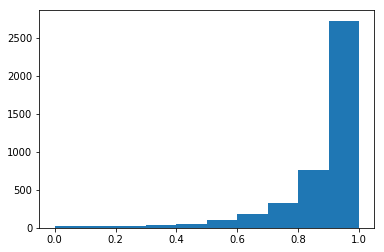

In [165]:
plt.hist(f1s)

In [729]:
i = 0

susp_path, src_path = test_paths[i]

susp_text = open(data_dir + susp_path).read()
src_text = open(data_dir + src_path).read()

for (src_start, src_end), (susp_start, susp_end) in out_detections_list[i]:
    lbl = "OK" if (susp_start, susp_end, src_start, src_end) in pairs_dict[susp_path, src_path] else "FAIL"
    print(lbl)
    print(susp_start, susp_end, src_start, src_end)
    print(repr(susp_text[susp_start:susp_end]))
    print(repr(src_text[src_start:src_end]))
    print()

FAIL
10385 10972 7126 7538
'Уподобляя Вселенную некоему большому  «часовому механизму», он пришел к интересному выводу,\nчто этот механизм был раз и навсегда когда-то заведен «богом», и им же был\nдан так называемый «первый толчок», в результате чего механизм «сработал» и только\nпосле этого все небесные тела пришли в вечное движение вокруг определенного центра.\nПосле всех его высказываний относительно церкви можно только предполагать, насколько сильно он воззвел из убеждения в тлен.\nОднако еще при жизни Ньютон смог вкусил сладость величайшей славы.\nОн являлся почетным членом многих научных сообществ и академий'
'Однако сам Ньютон не был атеистом.\nУподобляя Вселенную большому «часовому механизму», он пришел к выводу, что этот механизм раз и навсегда когда-то заведен «богом» и им же был дан «первый толчок», в результате чего механизм «сработал» и только после этого все небесные тела пришли в вечное движение.\n\nЕще при жизни Ньютон вкусил сладость величайшей славы.\nОн был почетным 

---